# Deep learning techniques to identify the composer of a music piece

**Objective**  
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

**Dataset**  
The project will use a dataset consisting of musical scores from various composers. The dataset contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

## Data Collection

### Install required libraries

In [1]:
import sys

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    print("Running on Colab: Installing fluidsynth and dependencies...")

    # Install correct pyfluidsynth
    !pip install pyfluidsynth

    # Install system fluidsynth and download a SoundFont
    !apt-get update -qq
    !apt-get install -y fluidsynth

    # Download a default SoundFont
    !wget -q -O /usr/share/sounds/sf2/FluidR3_GM.sf2 https://github.com/urish/candymidi/raw/master/assets/FluidR3_GM.sf2
else:
    print("Not running on Colab. Skipping system package installation.")


Not running on Colab. Skipping system package installation.


In [1]:
# Import all dependent libraries
import os
import csv
import zipfile
import shutil

from pathlib import Path
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import keras.optimizers
import tensorflow as tf

# Music related libraries
import music21
from music21 import converter, instrument, note, chord, tempo
try:
    import pretty_midi
except ImportError:
    !pip install pretty_midi
    import pretty_midi
import librosa
import librosa.display
try:
    import fluidsynth
except ImportError:
    !pip install pyfluidsynth
    import fluidsynth

import soundfile as sf

from tqdm import tqdm
from collections import Counter

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Deep Learning Libraries
from keras.models import Sequential,load_model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Activation
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences # not used , should we remove it?
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D,
                                     Dense, InputLayer)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import keras_tuner as kt

from collections import Counter

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/Users/johnny/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Function to check if running from colab
def is_running_on_colab():
  return 'google.colab' in str(get_ipython())

if is_running_on_colab():
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive' , force_remount=True)
  root_path = '/content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project'
else:
  print('Not running on Colab')
  root_path = '.'

Not running on Colab


In [3]:
# File path in Google Drive
file_path = os.path.join(root_path, 'Composer_Dataset.zip')

# Extract file path
# Check if Kaggle dataset already exists
extract_path = os.path.join(root_path, 'Kaggle_Composer_Dataset')

if not os.path.exists(extract_path):
    extract_path = os.path.join(root_path, 'Composer_Dataset')

print(f"Using dataset: {extract_path}")

# Dataset folders
path = Path(extract_path)
if "Kaggle_Composer_Dataset" in path.name:
    dataset_path = extract_path
else:
    dataset_path = os.path.join(extract_path, 'Composer_Dataset/NN_midi_files_extended')
print(f"Using extracted dataset: {dataset_path}")

# CSV index file
csv_file = os.path.join(dataset_path, 'composer_dataset_index.csv')

Using dataset: ./Kaggle_Composer_Dataset
Using extracted dataset: ./Kaggle_Composer_Dataset


In [4]:
# Check if folder already exists
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [ ]:
# Function to clean the folders
def delete_hidden_folders(root_folder):
    for root, dirs, _ in os.walk(root_folder):
        for d in dirs:
            if d.startswith('.'):
                dir_path = os.path.join(root, d)
                print(f"Deleting hidden folder: {dir_path}")
                shutil.rmtree(dir_path)
            elif d == '__MACOSX':
                dir_path = os.path.join(root, d)
                print(f"Deleting __MACOSX folder: {dir_path}")
                shutil.rmtree(dir_path)

# Run this on the outer Composer_Dataset
delete_hidden_folders(extract_path)

## Data Pre-processing

In [ ]:
# Function to create index files
def create_midi_file_index_csv(root_dir, output_csv):
    rows = []

    path = Path(root_dir)
    if "Kaggle_Composer_Dataset" in path.name:
        split_folders = ['train', 'test', 'val']
    else:
        split_folders = ['train', 'test', 'dev']

    for split in split_folders:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue

        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if not os.path.isdir(composer_path) or composer.startswith('.'):
                continue

            for filename in os.listdir(composer_path):
                if not filename.endswith('.mid') or filename.startswith('.'):
                    continue

                filepath = os.path.join(split, composer, filename)
                rows.append({
                    'split': split,
                    'composer': composer,
                    'filename': filename,
                    'filepath': filepath
                })

    # Write to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['split', 'composer', 'filename', 'filepath'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"CSV created: {output_csv} with {len(rows)} entries.")

In [ ]:
# Create index csv file
create_midi_file_index_csv(root_dir=dataset_path, output_csv=csv_file)

CSV created: ./Kaggle_Composer_Dataset/composer_dataset_index.csv with 1660 entries.


## Feature Extraction

In [ ]:
# Define feature extraction function
def extract_midi_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        num_instruments = len(midi_data.instruments)
        notes = [note for inst in midi_data.instruments if not inst.is_drum for note in inst.notes]
        if not notes:
            raise ValueError("No notes found.")

        velocities = [note.velocity for note in notes]
        start_times = [note.start for note in notes]
        end_times = [note.end for note in notes]
        pitches = [note.pitch for note in notes]
        durations = [e - s for s, e in zip(start_times, end_times)]

        onsets = sorted(start_times)
        offsets = sorted(end_times)

        avg_velocity = np.mean(velocities)
        max_velocity = np.max(velocities)
        velocity_variance = np.var(velocities)
        pitch_variance = np.var(pitches)
        avg_interval = np.mean(np.diff(sorted(pitches))) if len(pitches) > 1 else 0
        avg_note_duration = np.mean(durations)
        note_density = len(notes) / midi_data.get_end_time() if midi_data.get_end_time() else 0
#        polyphony = np.mean([len(midi_data.get_active_notes(t)) for t in start_times])
        polyphony_list = []
        for i in range(len(onsets)):
            count = sum(1 for s, e in zip(onsets, offsets) if s <= onsets[i] < e)
            polyphony_list.append(count)

        polyphony = np.mean(polyphony_list)
        rhythmic_density = len(set(start_times)) / midi_data.get_end_time() if midi_data.get_end_time() else 0

        pitch_classes = np.zeros(12)
        for p in pitches:
            pitch_classes[p % 12] += 1
        pitch_classes /= len(pitches)

        #chord_density = sum(1 for t in np.arange(0, midi_data.get_end_time(), 0.5)
        #                    if len(midi_data.get_chords(t, t + 0.5)) > 0) / midi_data.get_end_time()
        # Approximate chord_density by counting overlapping notes (3+ notes = chord)
        time_grid = np.arange(0, midi_data.get_end_time(), 0.5)
        chord_count = 0

        for t in time_grid:
            active_notes = [note for note in notes if note.start <= t < note.end]
            if len(active_notes) >= 3:
                chord_count += 1

        chord_density = chord_count / len(time_grid) if len(time_grid) > 0 else 0

        pitch_transitions = np.mean(np.abs(np.diff(pitches))) if len(pitches) > 1 else 0
        tempo = midi_data.get_tempo_changes()[1].mean() if len(midi_data.get_tempo_changes()[1]) > 0 else 120
        key_sig = midi_data.key_signature_changes
        Key = key_sig[0].key_number if key_sig else np.nan

        return {
            "num_instruments": num_instruments,
            "velocity_variance": velocity_variance,
            "polyphony": polyphony,
            "pitch_variance": pitch_variance,
            "note_density": note_density,
            "pitch_class_0": pitch_classes[0],
            "pitch_class_1": pitch_classes[1],
            "pitch_class_2": pitch_classes[2],
            "pitch_class_3": pitch_classes[3],
            "pitch_class_4": pitch_classes[4],
            "pitch_class_5": pitch_classes[5],
            "pitch_class_6": pitch_classes[6],
            "pitch_class_7": pitch_classes[7],
            "pitch_class_8": pitch_classes[8],
            "pitch_class_9": pitch_classes[9],
            "pitch_class_10": pitch_classes[10],
            "pitch_class_11": pitch_classes[11],
            "avg_velocity": avg_velocity,
            "chord_density": chord_density,
            "max_velocity": max_velocity,
            "avg_interval": avg_interval,
            "rhythmic_density": rhythmic_density,
            "tempo": tempo,
            "avg_note_duration": avg_note_duration,
            "pitch_transitions": pitch_transitions,
            "Key": Key
        }
    except Exception as e:
        print(f"Error parsing {midi_path}: {e}")
        return {f: np.nan for f in [
            "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
            "pitch_class_0", "pitch_class_1", "pitch_class_2", "pitch_class_3", "pitch_class_4",
            "pitch_class_5", "pitch_class_6", "pitch_class_7", "pitch_class_8", "pitch_class_9",
            "pitch_class_10", "pitch_class_11", "avg_velocity", "chord_density", "max_velocity",
            "avg_interval", "rhythmic_density", "tempo", "avg_note_duration", "pitch_transitions",
            "Key"
        ]}


In [ ]:
# Load your previously generated CSV
df = pd.read_csv(csv_file)

# Extract features
tqdm.pandas(desc="Extracting MIDI Features")
features_df = df["filepath"].progress_apply(lambda path: pd.Series(extract_midi_features(str(Path(dataset_path) / path))))
full_df = pd.concat([df, features_df], axis=1)

# Write it to the csv file
full_df.to_csv(csv_file, index=False)

# Print
full_df.head()

Extracting MIDI Features:   1%|            | 13/1660 [00:23<1:05:35,  2.39s/it]

Error parsing Kaggle_Composer_Dataset/train/Mozart/Mozart_0048.mid: Could not decode key with 2 flats and mode 2


Extracting MIDI Features:   6%|▋          | 103/1660 [02:48<1:02:46,  2.42s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting MIDI Features:  85%|██████████▏ | 1404/1660 [25:03<01:10,  3.65it/s]

Error parsing Kaggle_Composer_Dataset/val/Chopin/Chopin_0137.mid: MThd not found. Probably not a MIDI file


Extracting MIDI Features:  86%|██████████▎ | 1431/1660 [25:55<05:57,  1.56s/it]

Error parsing Kaggle_Composer_Dataset/val/Beethoven/Beethoven_0004.mid: Could not decode key with 3 flats and mode 255


Extracting MIDI Features: 100%|████████████| 1660/1660 [27:14<00:00,  1.02it/s]


split composer         filename                      filepath  \
0  train   Mozart  Mozart_0103.mid  train/Mozart/Mozart_0103.mid   
1  train   Mozart  Mozart_0063.mid  train/Mozart/Mozart_0063.mid   
2  train   Mozart  Mozart_0077.mid  train/Mozart/Mozart_0077.mid   
3  train   Mozart  Mozart_0088.mid  train/Mozart/Mozart_0088.mid   
4  train   Mozart  Mozart_0248.mid  train/Mozart/Mozart_0248.mid   

   num_instruments  velocity_variance  polyphony  pitch_variance  \
0             10.0         416.877661   9.043739      163.539849   
1              6.0         203.893338   8.381113      150.448508   
2              2.0         189.444842   2.433950      109.876640   
3              1.0           0.000000   1.000000       26.531122   
4             11.0         804.178713  10.103871      159.927506   

   note_density  pitch_class_0  ...  pitch_class_11  avg_velocity  \
0     25.055833       0.046735  ...        0.107849     84.384062   
1     12.640908       0.173693  ...        0.089376     83.380270   
2      9.172174       0.128961  ...        0.010041     64.232507   
3      5.299415       0.165899  ...        0.092166     88.000000   
4     32.789952       0.194032  ...        0.099954    108.315417   

   chord_density  max_velocity  avg_interval  rhythmic_density       tempo  \
0       0.831461         105.0      0.017381          3.633021  120.259253   
1       0.893617         115.0      0.046414          3.538602   71.333406   
2       0.346763         110.0      0.018832          6.133010  153.984159   
3       0.000000          88.0      0.048499          5.299415  120.000000   
4       0.860246         127.0      0.003745          7.384256   64.074865   

   avg_note_duration  pitch_transitions   Key  
0           0.268799           3.400959   0.0  
1           0.488797           4.438819   0.0  
2           0.231632           3.724733  10.0  
3           0.142209           3.251732   0.0  
4           0.212880           3.218874   0.0  

[5 rows x 30 columns]

Features extracted from the MIDI files using `pretty_midi`

**Structural Features**
* **num\_instruments**: Number of distinct instrument tracks in the MIDI.
* **tempo**: Average tempo (beats per minute) across the piece.
* **Key**: Estimated musical key represented as a numerical class (0–23 for major/minor keys).

**Pitch-Based Features**
* **pitch\_variance**: Variability in pitch values used across all notes.
* **pitch\_class\_0 to pitch\_class\_11**: Fraction of notes in each of the 12 pitch classes (C, C#, ..., B), giving a tonal distribution.
* **pitch\_transitions**: Count of pitch changes between consecutive notes, indicating melodic movement.
* **avg\_interval**: Average pitch interval between successive notes.

**Rhythm and Timing Features**

* **note\_density**: Notes per second; indicates how "busy" the composition is.
* **avg\_note\_duration**: Average duration of notes.
* **rhythmic\_density**: Number of distinct note onsets per second; reflects rhythmic complexity.
* **polyphony**: Average number of simultaneous notes played (chords or dense textures).

**Velocity/Dynamics Features**

* **avg\_velocity**: Mean velocity (loudness) of notes.
* **max\_velocity**: Highest note velocity in the piece.
* **velocity\_variance**: How varied the note dynamics are.
* **chord\_density**: Fraction of overlapping note events that likely form chords.

## Exploratory Data Analysis

### Dataset overview

In [5]:
# Load the uploaded dataset
df = pd.read_csv(csv_file)

# Show basic info
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   split              1660 non-null   object 
 1   composer           1660 non-null   object 
 2   filename           1660 non-null   object 
 3   filepath           1660 non-null   object 
 4   num_instruments    1657 non-null   float64
 5   velocity_variance  1657 non-null   float64
 6   polyphony          1657 non-null   float64
 7   pitch_variance     1657 non-null   float64
 8   note_density       1657 non-null   float64
 9   pitch_class_0      1657 non-null   float64
 10  pitch_class_1      1657 non-null   float64
 11  pitch_class_2      1657 non-null   float64
 12  pitch_class_3      1657 non-null   float64
 13  pitch_class_4      1657 non-null   float64
 14  pitch_class_5      1657 non-null   float64
 15  pitch_class_6      1657 non-null   float64
 16  pitch_class_7      1657 

split composer         filename                      filepath  \
0  train   Mozart  Mozart_0103.mid  train/Mozart/Mozart_0103.mid   
1  train   Mozart  Mozart_0063.mid  train/Mozart/Mozart_0063.mid   
2  train   Mozart  Mozart_0077.mid  train/Mozart/Mozart_0077.mid   
3  train   Mozart  Mozart_0088.mid  train/Mozart/Mozart_0088.mid   
4  train   Mozart  Mozart_0248.mid  train/Mozart/Mozart_0248.mid   

   num_instruments  velocity_variance  polyphony  pitch_variance  \
0             10.0         416.877661   9.043739      163.539849   
1              6.0         203.893338   8.381113      150.448508   
2              2.0         189.444842   2.433950      109.876640   
3              1.0           0.000000   1.000000       26.531122   
4             11.0         804.178713  10.103871      159.927506   

   note_density  pitch_class_0  ...  pitch_class_11  avg_velocity  \
0     25.055833       0.046735  ...        0.107849     84.384062   
1     12.640908       0.173693  ...        0.089376     83.380270   
2      9.172174       0.128961  ...        0.010041     64.232507   
3      5.299415       0.165899  ...        0.092166     88.000000   
4     32.789952       0.194032  ...        0.099954    108.315417   

   chord_density  max_velocity  avg_interval  rhythmic_density       tempo  \
0       0.831461         105.0      0.017381          3.633021  120.259253   
1       0.893617         115.0      0.046414          3.538602   71.333406   
2       0.346763         110.0      0.018832          6.133010  153.984159   
3       0.000000          88.0      0.048499          5.299415  120.000000   
4       0.860246         127.0      0.003745          7.384256   64.074865   

   avg_note_duration  pitch_transitions   Key  
0           0.268799           3.400959   0.0  
1           0.488797           4.438819   0.0  
2           0.231632           3.724733  10.0  
3           0.142209           3.251732   0.0  
4           0.212880           3.218874   0.0  

[5 rows x 30 columns]

### Data cleaning

In [6]:
# Failed midi files
failed = df[df["num_instruments"].isna()]
print("Failed midi files: ")
print(failed[["composer", "filename", "filepath"]])

# Remove rows with critical feature extraction failure (most features are NaN)
df = df.dropna(subset=["num_instruments"])

# Impute remaining missing values (e.g., "Key") using column means
df = df.fillna(df.mean(numeric_only=True))

print(f"\nCleaned dataset. Remaining entries: {len(df)}")

Failed midi files: 
       composer            filename                          filepath
12       Mozart     Mozart_0048.mid      train/Mozart/Mozart_0048.mid
1400     Chopin     Chopin_0137.mid        val/Chopin/Chopin_0137.mid
1430  Beethoven  Beethoven_0004.mid  val/Beethoven/Beethoven_0004.mid

Cleaned dataset. Remaining entries: 1657


### Data visualization

In [8]:
# Check number of files per composer and by split
composer_counts = df['composer'].value_counts()
split_counts = df['split'].value_counts()
composer_split_counts = df.groupby(['composer', 'split']).size().unstack(fill_value=0)

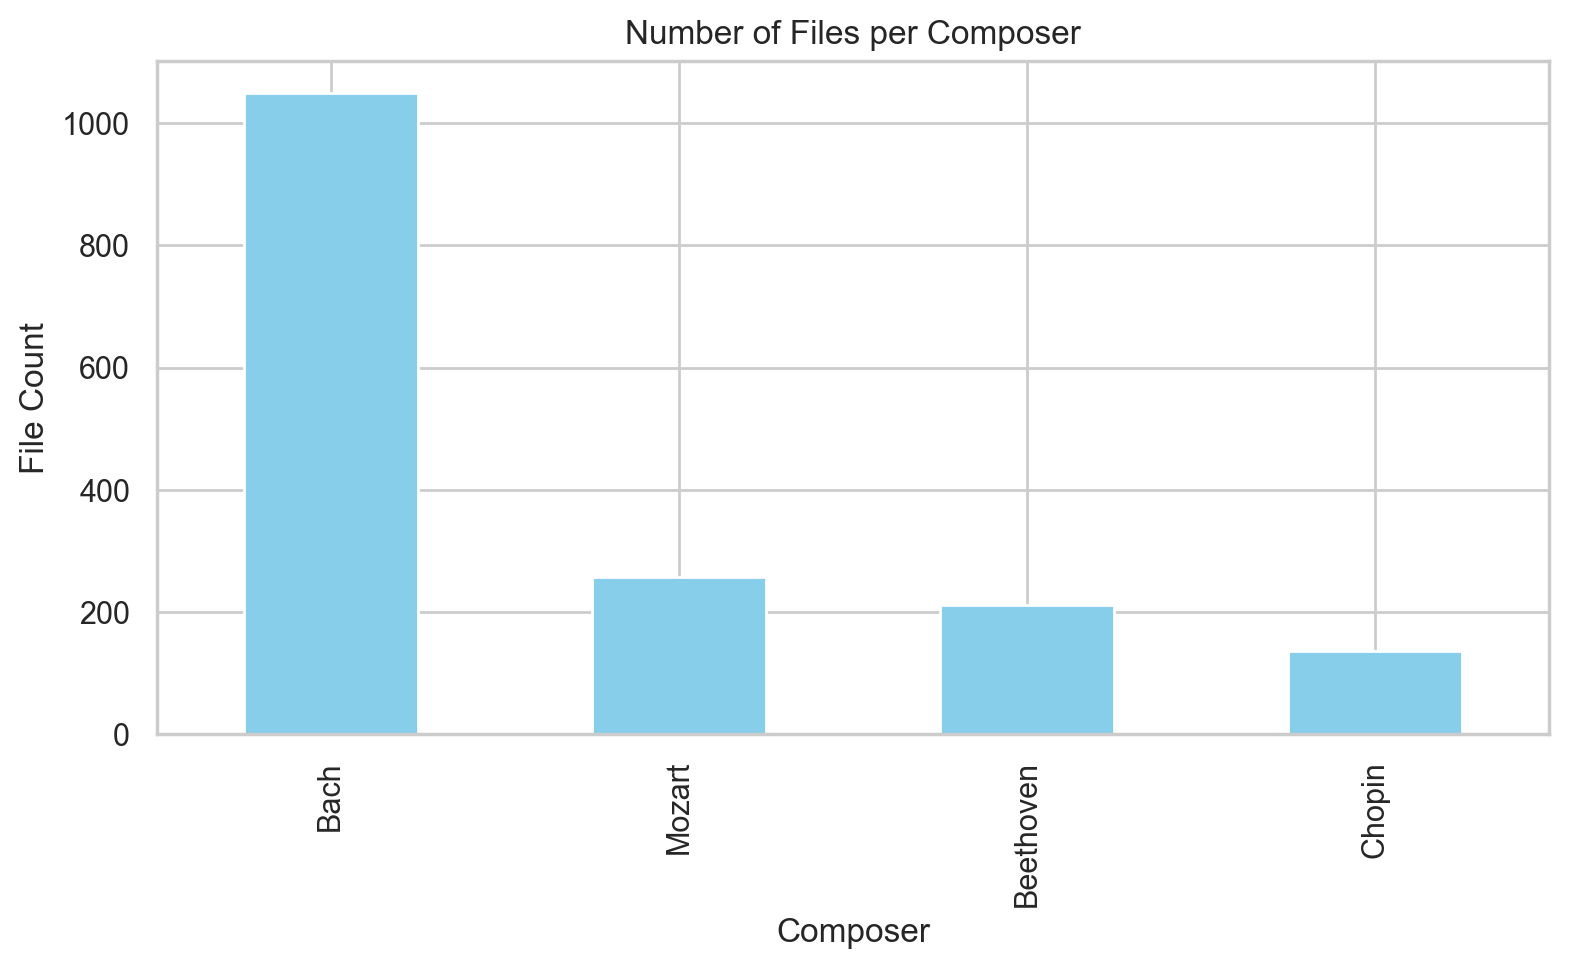

In [9]:
# Set plot style
sns.set(style="whitegrid")

# Number of files per composer
plt.figure(figsize=(8, 5))
composer_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files per Composer')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.tight_layout()
plt.show()

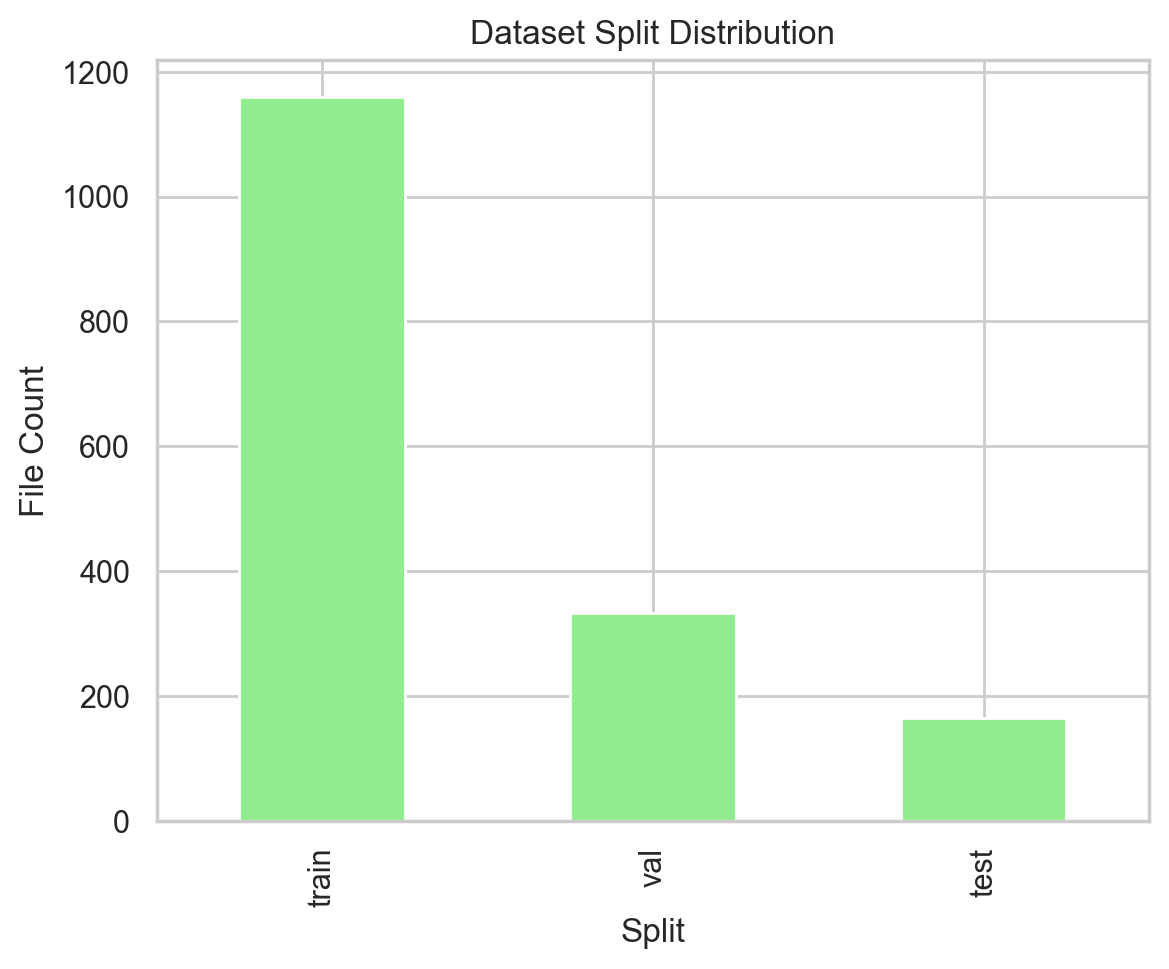

In [10]:
# Split distribution
plt.figure(figsize=(6, 5))
split_counts.plot(kind='bar', color='lightgreen')
plt.title('Dataset Split Distribution')
plt.ylabel('File Count')
plt.xlabel('Split')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

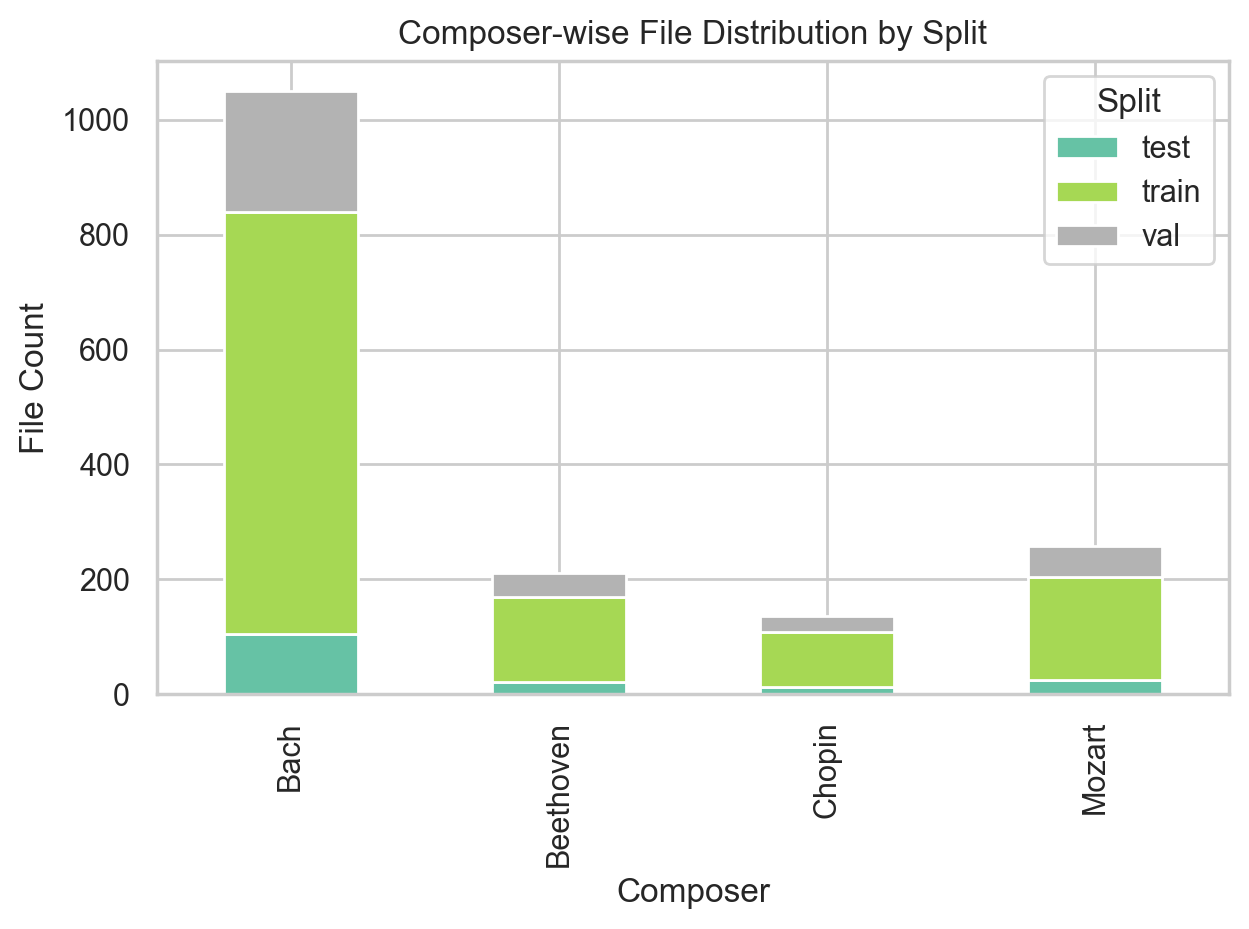

In [11]:
# Composer-wise split
plt.figure(figsize=(10, 6))
composer_split_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Composer-wise File Distribution by Split')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

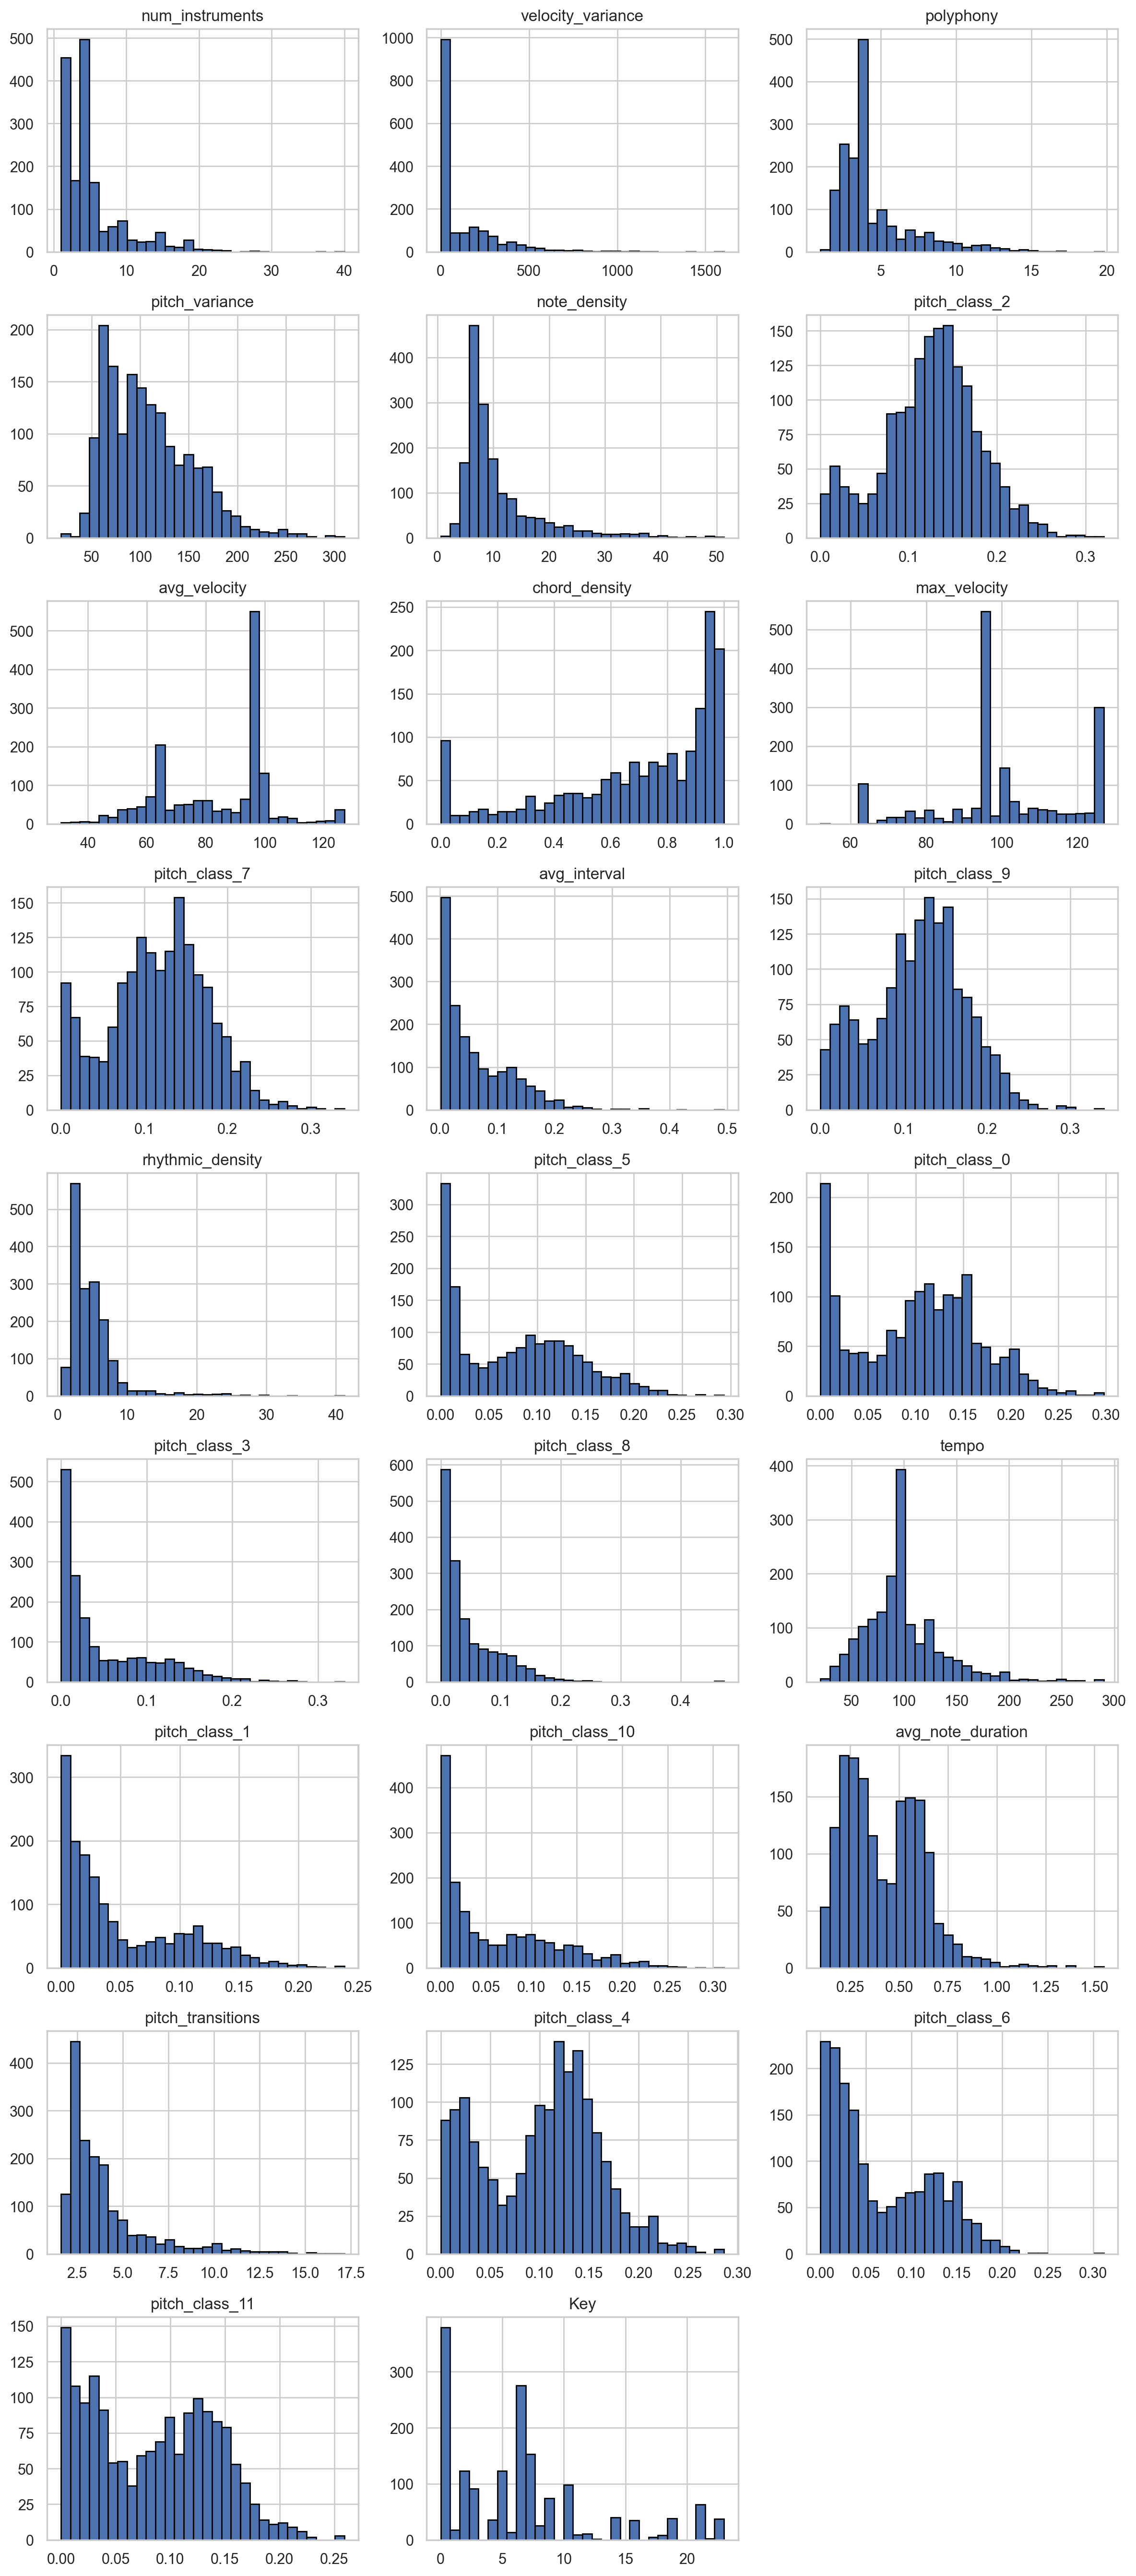

In [12]:
# Features to plot
features = [
    "num_instruments", "velocity_variance", "polyphony", "pitch_variance", "note_density",
    "pitch_class_2", "avg_velocity", "chord_density", "max_velocity", "pitch_class_7",
    "avg_interval", "pitch_class_9", "rhythmic_density", "pitch_class_5", "pitch_class_0",
    "pitch_class_3", "pitch_class_8", "tempo", "pitch_class_1", "pitch_class_10",
    "avg_note_duration", "pitch_transitions", "pitch_class_4", "pitch_class_6", "pitch_class_11",
    "Key"
]

# Determine grid dimensions for subplots
n_features = len(features)
ncols = 3
nrows = int(np.ceil(n_features / ncols))

plt.figure(figsize=(ncols * 4, nrows * 3))

# Plot distributions for each statistical feature
for i, feature in enumerate(features):
    plt.subplot(nrows, ncols, i + 1)
    data = df[feature].dropna()
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()

### Correlation analysis

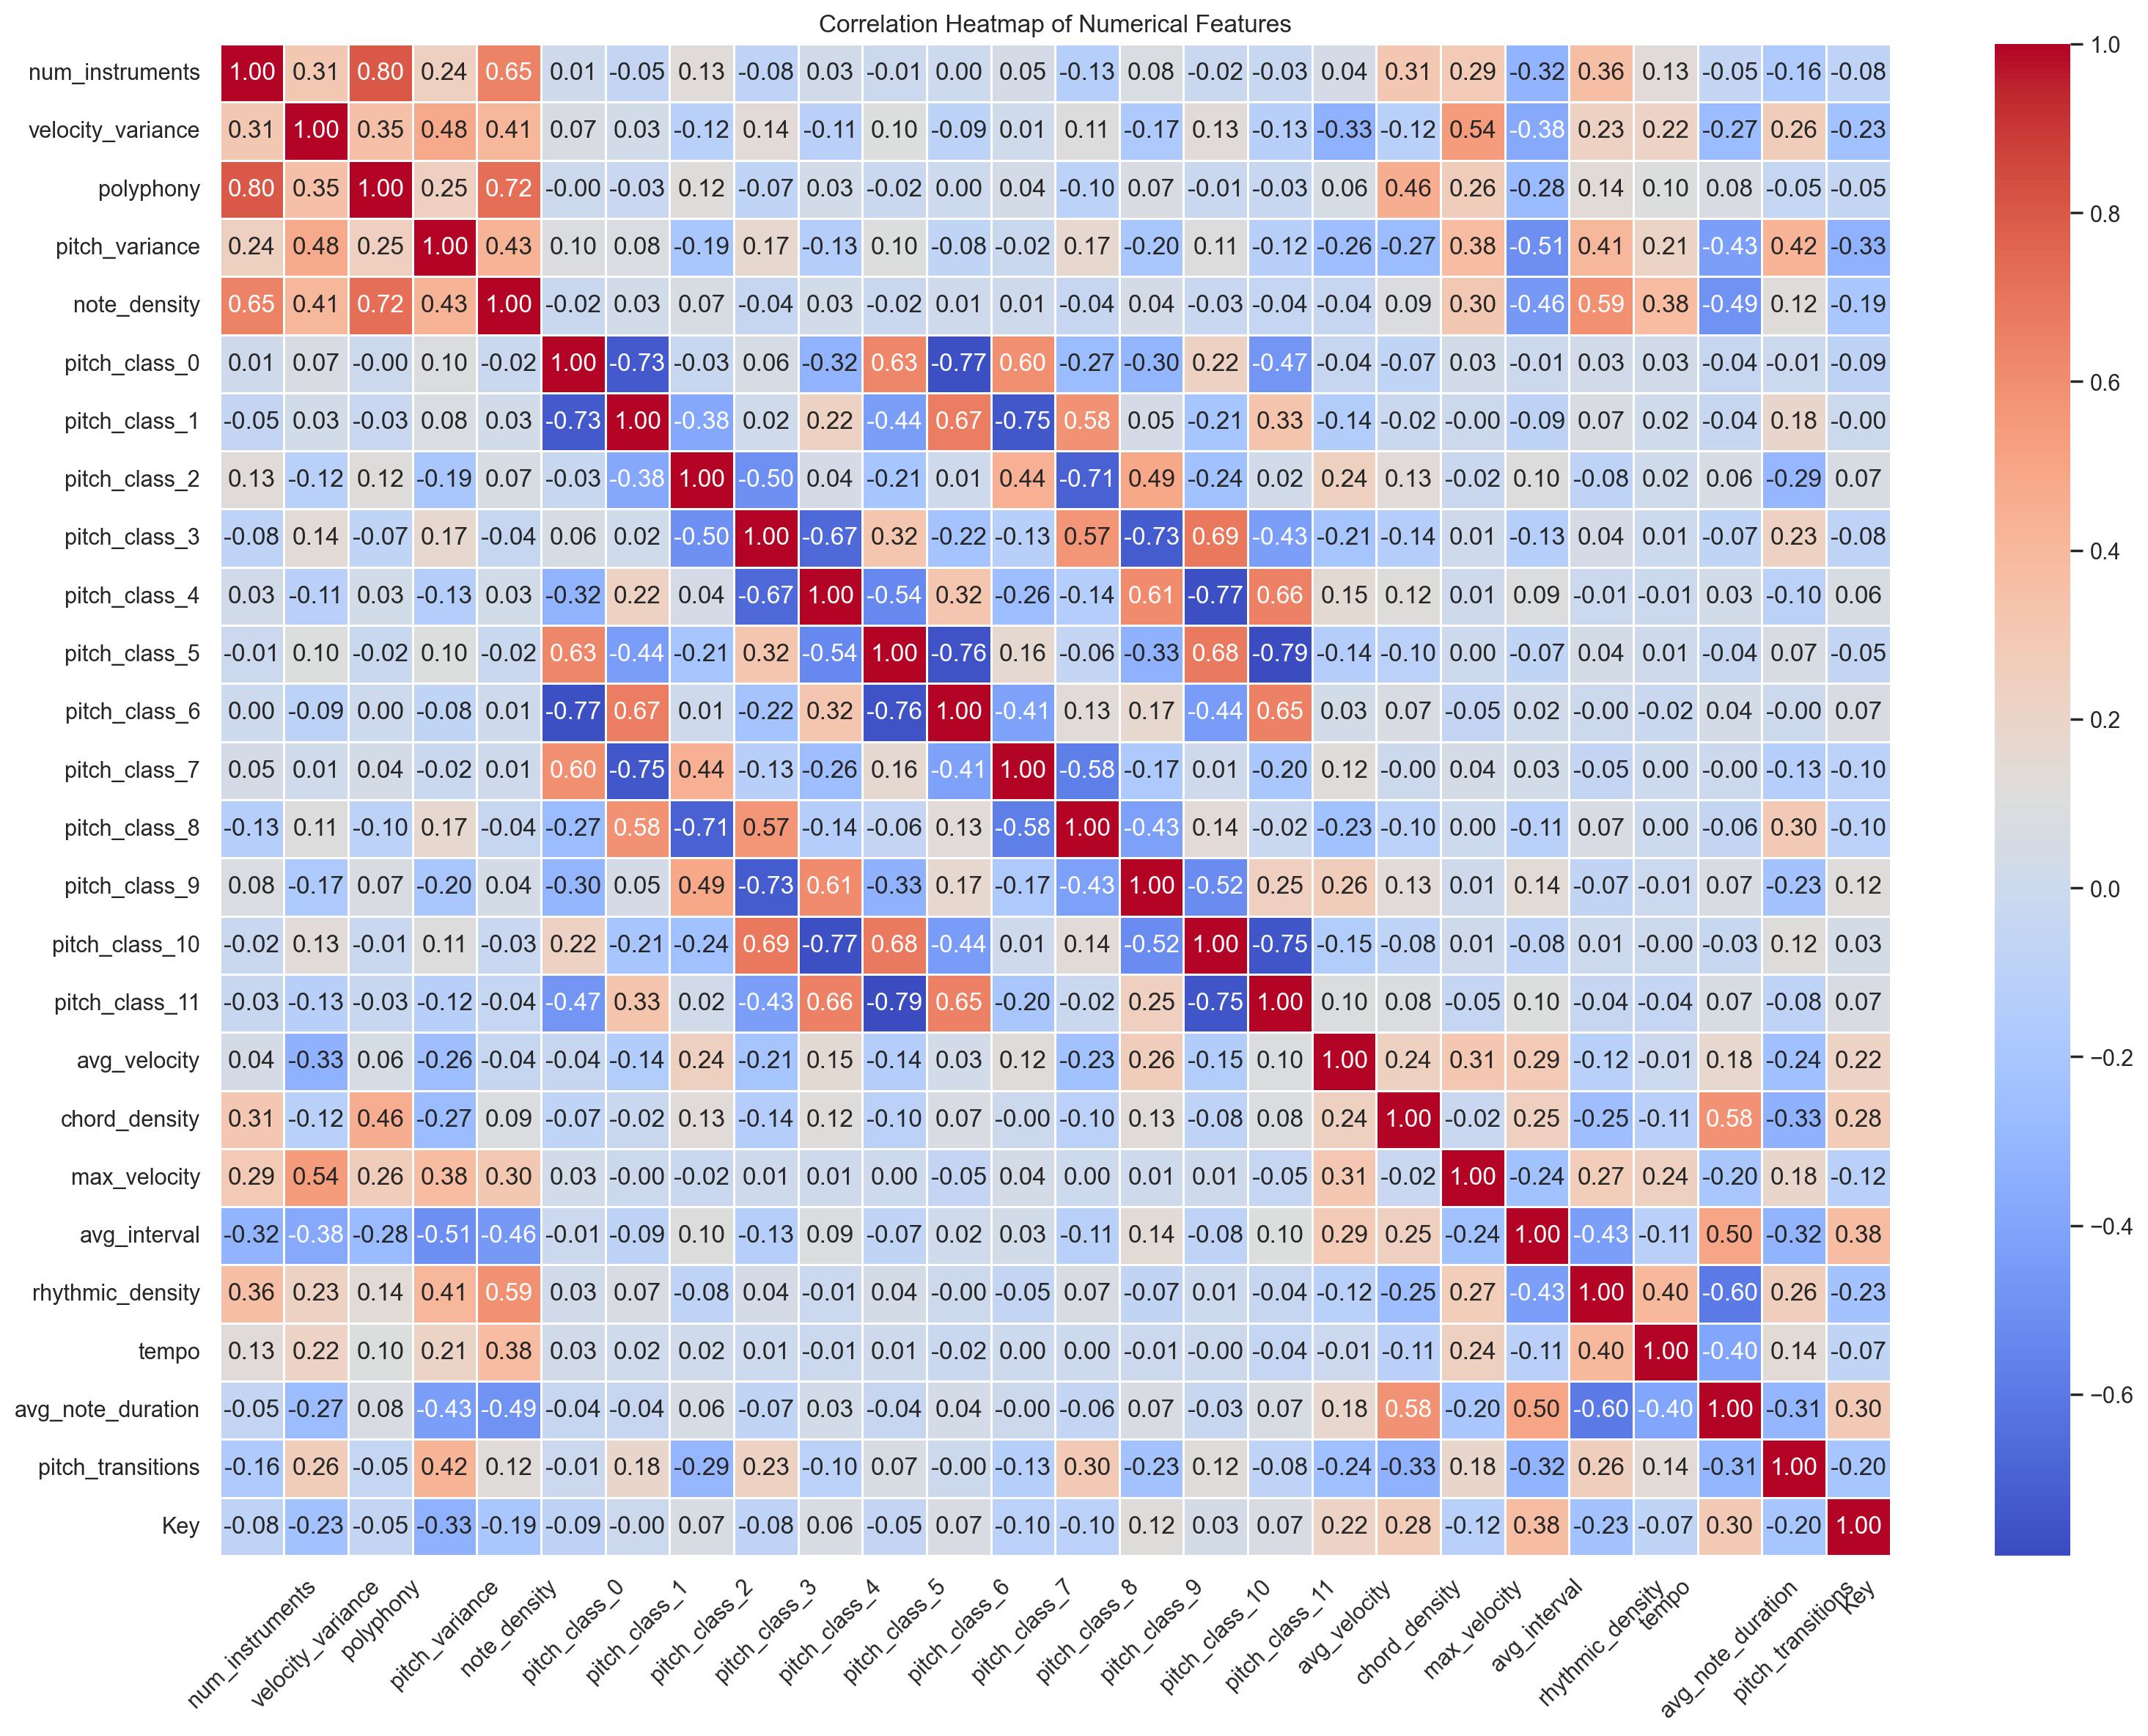

In [13]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

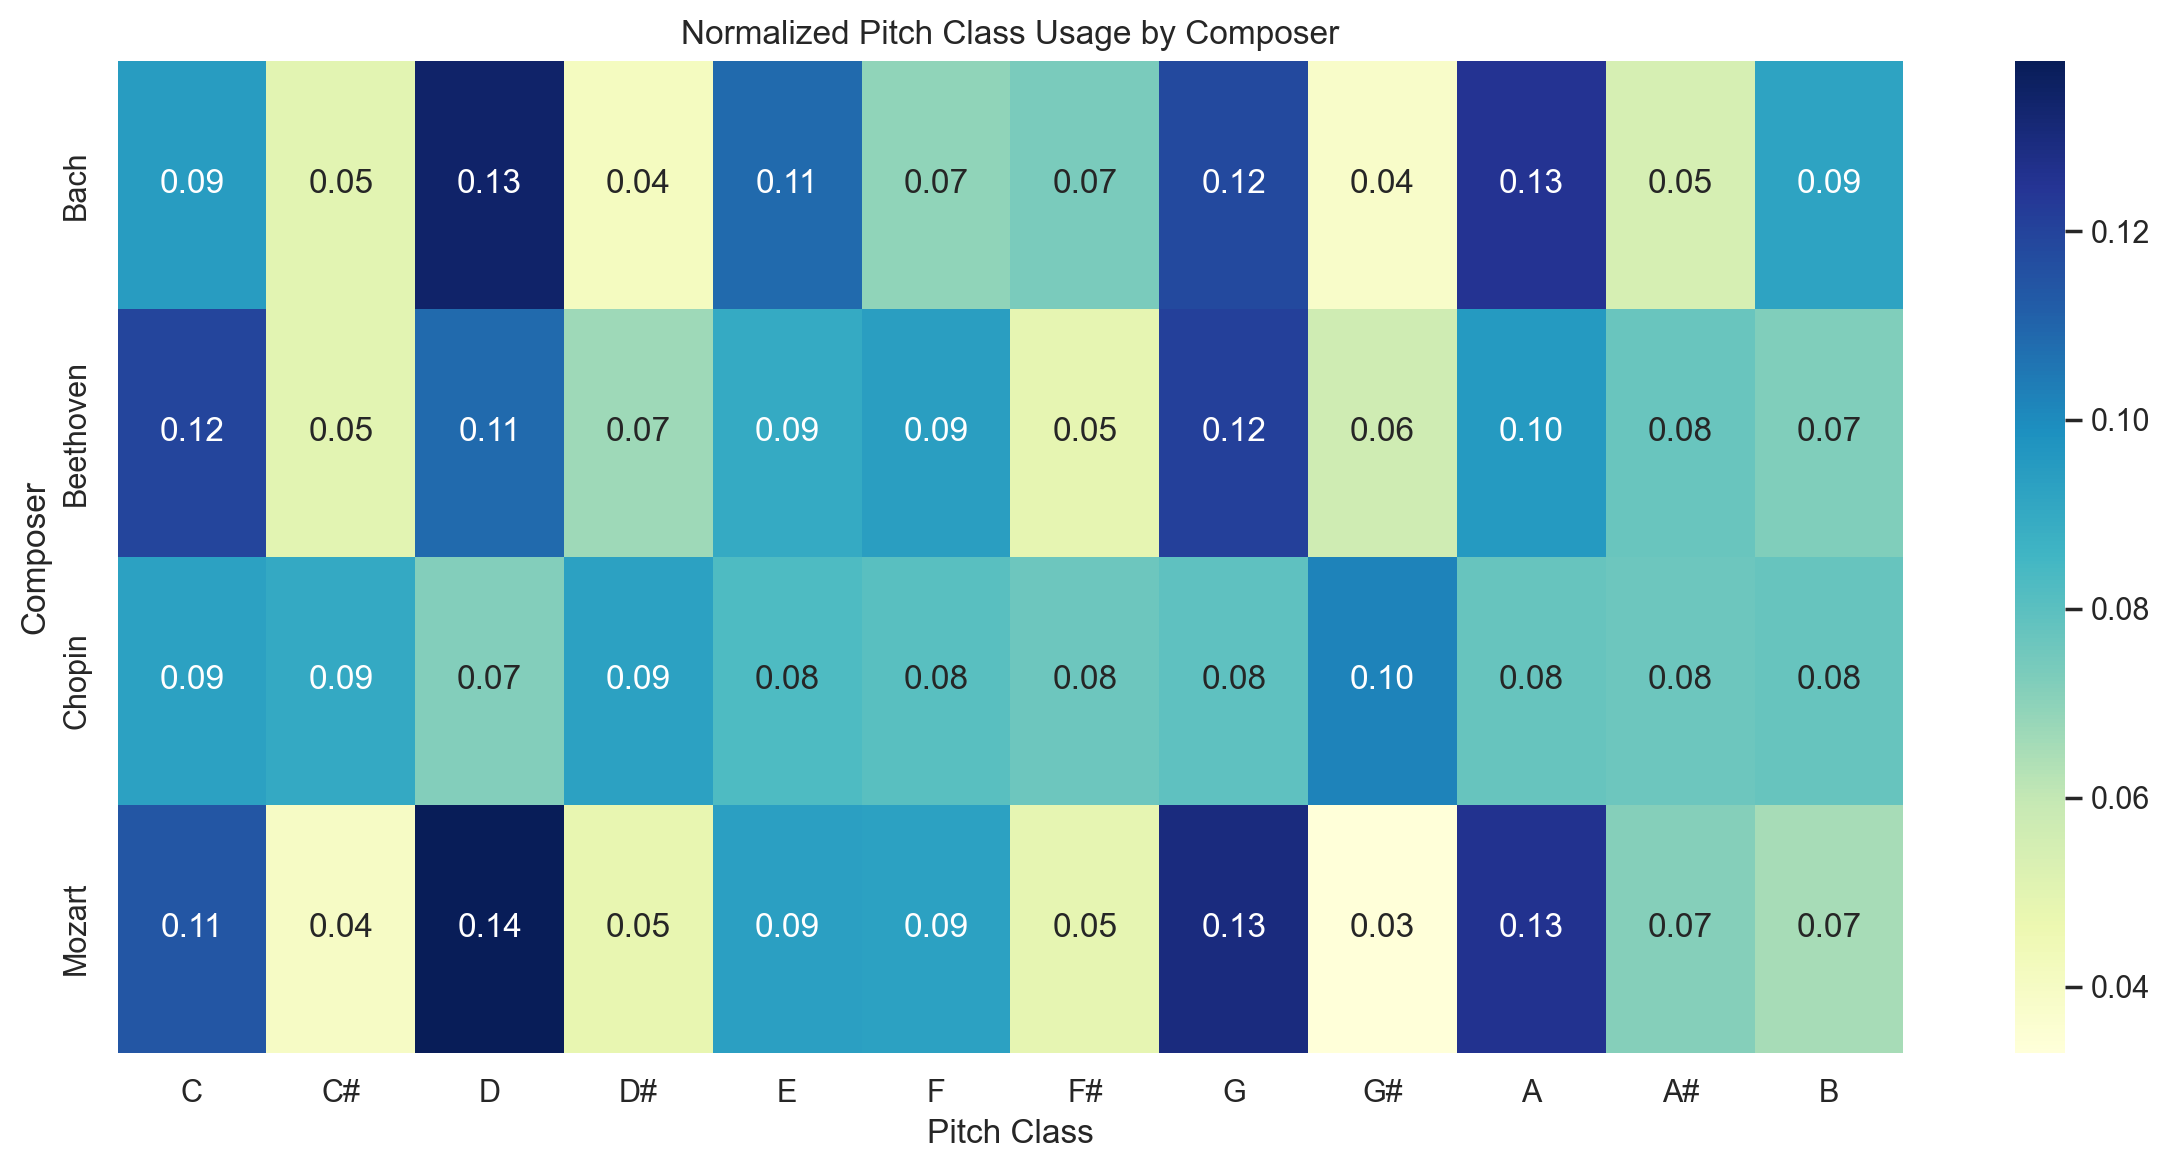

In [14]:
# Normalize pitch class usage by composer
pitch_classes = [f'pitch_class_{i}' for i in range(12)]
df_pitch = df.groupby('composer')[pitch_classes].mean()
df_pitch_normalized = df_pitch.div(df_pitch.sum(axis=1), axis=0)

# Rename columns to note names
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
df_pitch_normalized.columns = note_names

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(df_pitch_normalized, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Normalized Pitch Class Usage by Composer")
plt.xlabel("Pitch Class")
plt.ylabel("Composer")
plt.tight_layout()
plt.show()

## LSTM Model Building

### Base LSTM model

In [15]:
def create_sequences(data, targets, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

# Normalize the feature data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Encode labels (composer classification)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['composer'])

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length=5)

print("Input shape:", X_seq.shape)
print("Target shape:", y_seq.shape)


Input shape: (1652, 5, 26)
Target shape: (1652,)


In [16]:

lstm_model = Sequential([
    Input(shape=(5, 26), dtype='int32'),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_seq)), activation='softmax')  # For classification
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,508 (99.64 KB)

 Trainable params: 25,508 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

history = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4716 - loss: 1.2799 - val_accuracy: 0.7976 - val_loss: 0.7166
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - loss: 0.6155 - val_accuracy: 0.9215 - val_loss: 0.3419
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8550 - loss: 0.4073 - val_accuracy: 0.9335 - val_loss: 0.2091
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9200 - loss: 0.2793 - val_accuracy: 0.9456 - val_loss: 0.1812
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9301 - loss: 0.2424 - val_accuracy: 0.9486 - val_loss: 0.1488
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9464 - loss: 0.1835 - val_accuracy: 0.9275 - val_loss: 0.1653
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9592 - loss: 0.1391 - val_accuracy: 0.9486 - val_loss: 0.1234
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.1497 - val_accuracy: 0.9637 - val_loss:

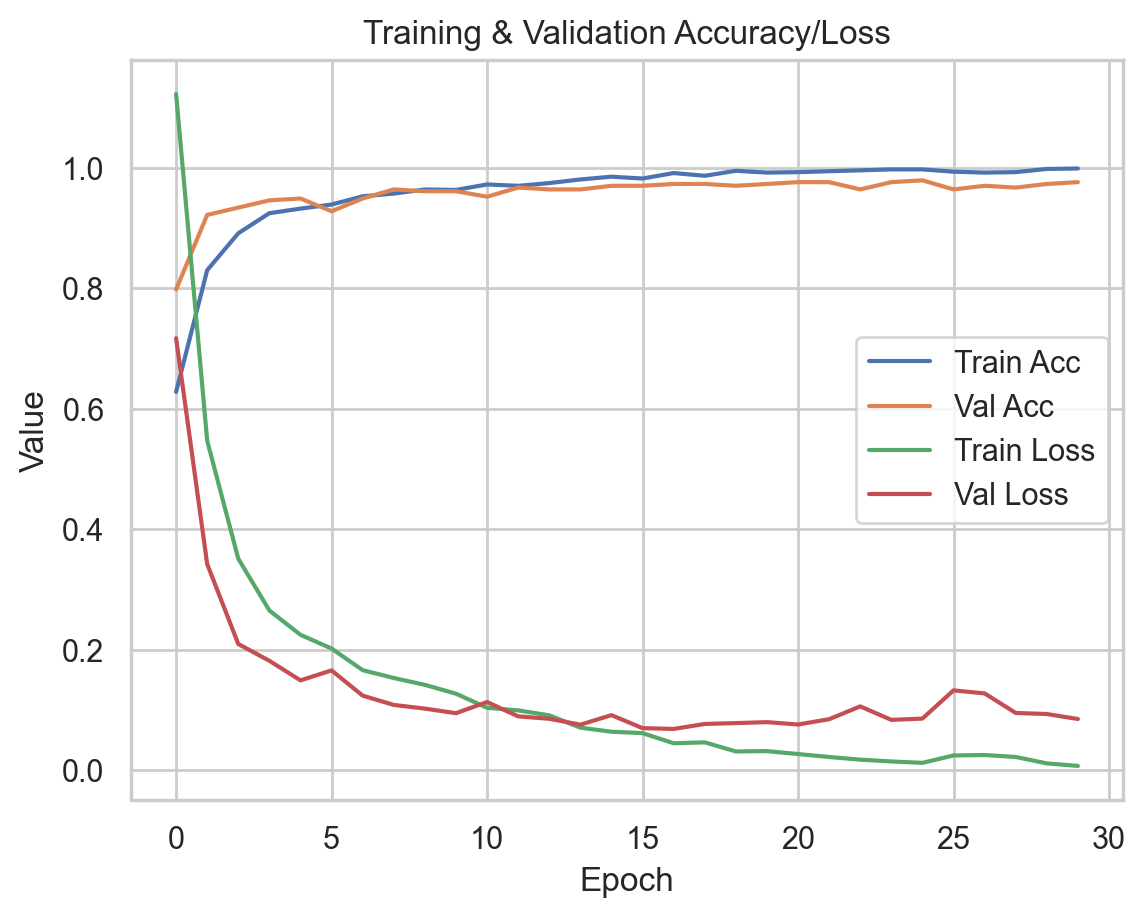

In [18]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## LSTM Model Evaluation

In [19]:

y_pred = lstm_model.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00       210
   Beethoven       0.95      0.91      0.93        43
      Chopin       0.90      0.96      0.93        27
      Mozart       0.96      0.96      0.96        51

    accuracy                           0.98       331
   macro avg       0.95      0.96      0.95       331
weighted avg       0.98      0.98      0.98       331



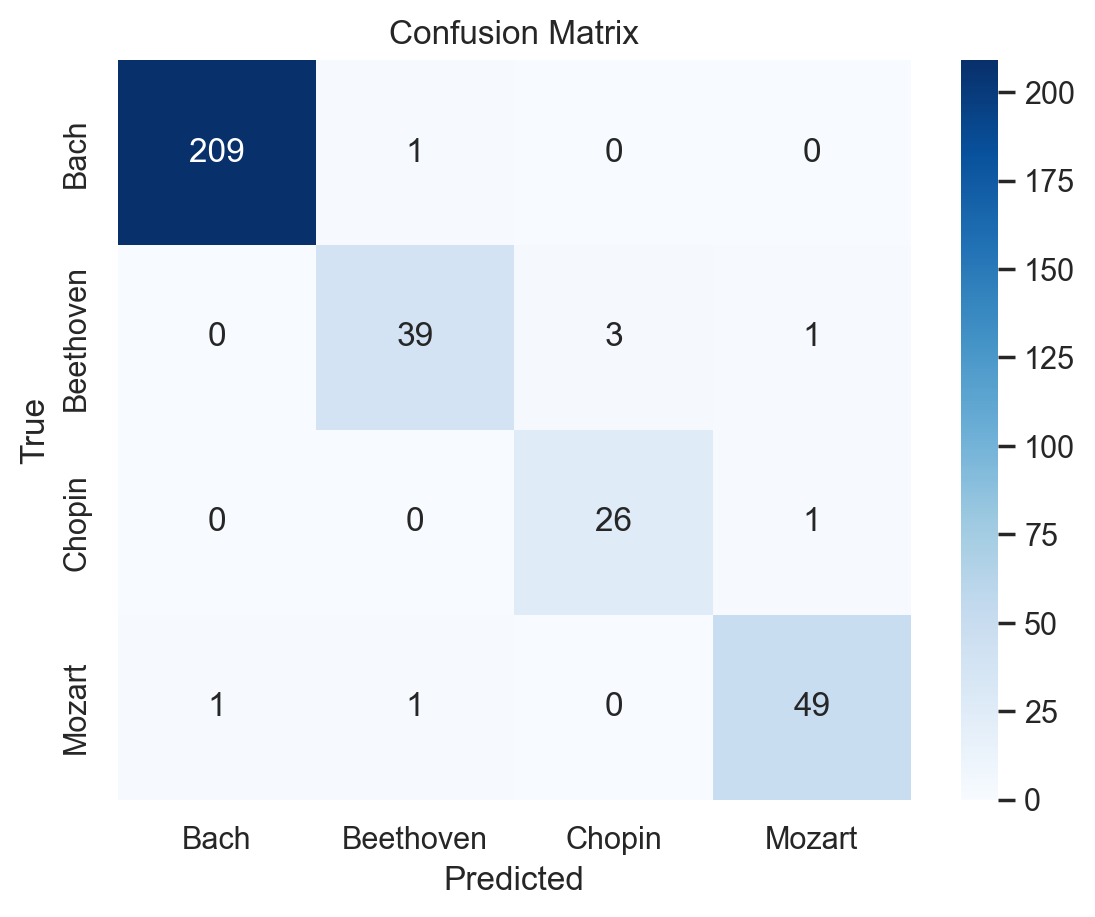

In [20]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## LSTM Model Optimization

In [21]:
def build_Opt_model(hp, n_vocab, sequence_length):
    """
    Builds the LSTM model using KerasTuner's HyperParameters.
    """
    model = Sequential()

    # Hyperparameters for LSTM units
    hp_lstm_units_1 = hp.Int('lstm_units_1', min_value=128, max_value=512, step=128)
    hp_lstm_units_2 = hp.Int('lstm_units_2', min_value=128, max_value=512, step=128)

    # Hyperparameter for Dropout rate
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    model.add(LSTM(
        units=hp_lstm_units_1,
        return_sequences=True,
        input_shape=(sequence_length, X_train.shape[2]) # Specify the input shape
    ))
    model.add(Dropout(hp_dropout_rate))
    model.add(LSTM(units=hp_lstm_units_2))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout_rate))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))

    # Hyperparameter for Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=['accuracy']
    )
    return model

In [22]:
OUTPUT_DIR = 'pipeline_output'
n_vocab = len(np.unique(y_seq))
SEQUENCE_LENGTH = 5

# --- Hyperparameter Optimization ---
print("\n--- Stage 2: Hyperparameter Optimization ---")
tuner = kt.Hyperband(
    lambda hp: build_Opt_model(hp, n_vocab, SEQUENCE_LENGTH),
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory=OUTPUT_DIR,
    project_name='maestro_lstm_tuning'
)


--- Stage 2: Hyperparameter Optimization ---


/Library/Python/3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Add a callback to stop training early if validation loss doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [24]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train, num_classes=n_vocab)
y_val_encoded = to_categorical(y_val, num_classes=n_vocab)

print("Starting hyperparameter search...")
tuner.search(
     X_train, y_train_encoded,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early]
)

Trial 90 Complete [00h 00m 04s]
val_accuracy: 0.9735848903656006

Best val_accuracy So Far: 0.99245285987854
Total elapsed time: 00h 06m 27s


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Optimal Hyperparameters ---")
#print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"LSTM Units 1: {best_hps.get('lstm_units_1')}")
print(f"LSTM Units 2: {best_hps.get('lstm_units_2')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate'):.2f}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# --- 3. Training the Optimal Model ---
print("\n--- Stage 3: Training the Optimal Model ---")
model = tuner.hypermodel.build(best_hps)

# Modify checkpoint to save the entire model in the recommended .keras format
checkpoint_path = os.path.join(OUTPUT_DIR, "best_model.keras")
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min',
    save_weights_only=False # Explicitly set to save the entire model
)

print("Training final model...")
history = model.fit(
    X_train,
    y_train_encoded,
    epochs=100, # Train for more epochs on the final model
    batch_size=128,
    validation_data=(X_val, y_val_encoded),
    callbacks=[checkpoint]
)

model = load_model(checkpoint_path) # Load the entire model


--- Optimal Hyperparameters ---
LSTM Units 1: 256
LSTM Units 2: 128
Dropout Rate: 0.20
Learning Rate: 0.001

--- Stage 3: Training the Optimal Model ---
Training final model...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6128 - loss: 1.0732 - val_accuracy: 0.9245 - val_loss: 1.0951
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8985 - loss: 0.3627 - val_accuracy: 0.8701 - val_loss: 0.9521
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9371 - loss: 0.2360 - val_accuracy: 0.8701 - val_loss: 0.8299
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9489 - loss: 0.1820 - val_accuracy: 0.8278 - val_loss: 0.7560
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9638 - loss: 0.1257 - val_accuracy: 0.8218 - val_loss: 0.6940
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9624 - loss: 0.1067 - val_accuracy: 0.7674 - val_loss: 0.6572
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - 

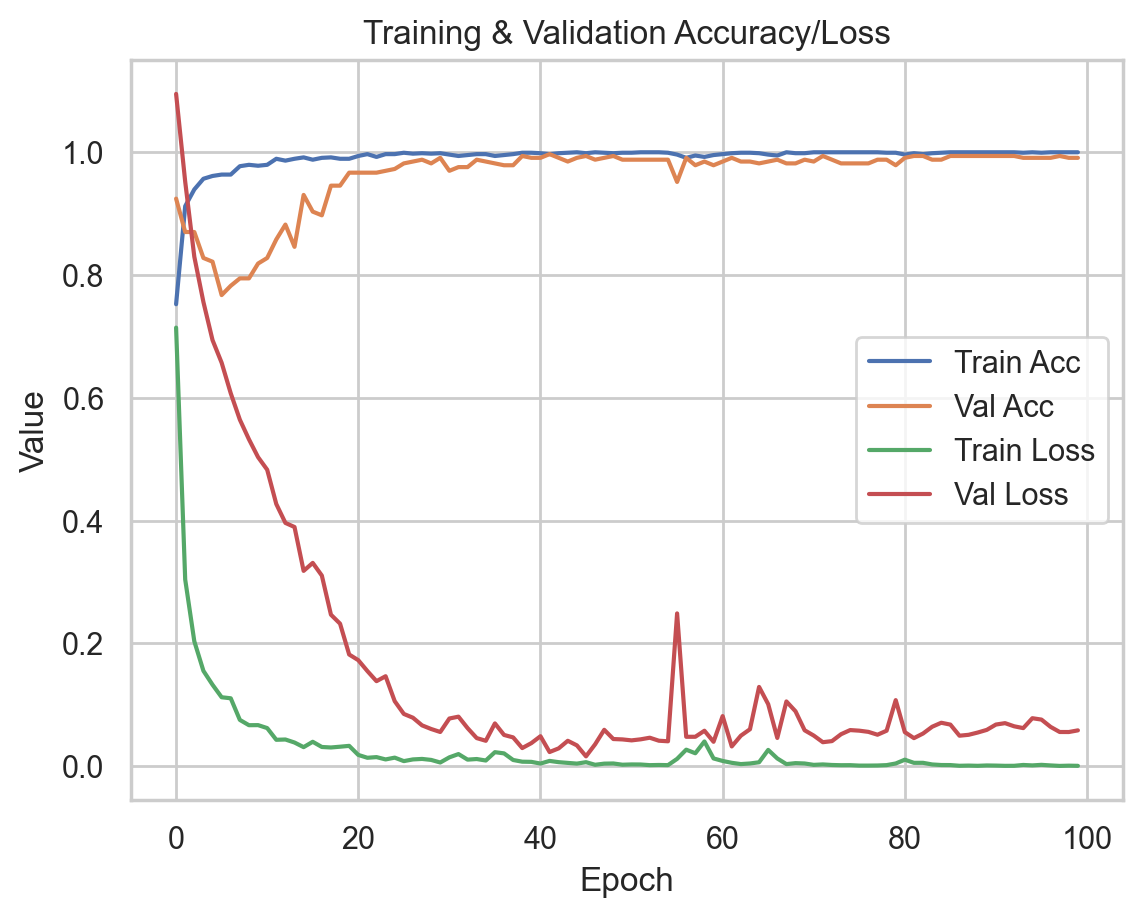

In [27]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
y_pred = model.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00       210
   Beethoven       0.96      1.00      0.98        43
      Chopin       1.00      0.96      0.98        27
      Mozart       1.00      1.00      1.00        51

    accuracy                           0.99       331
   macro avg       0.99      0.99      0.99       331
weighted avg       0.99      0.99      0.99       331



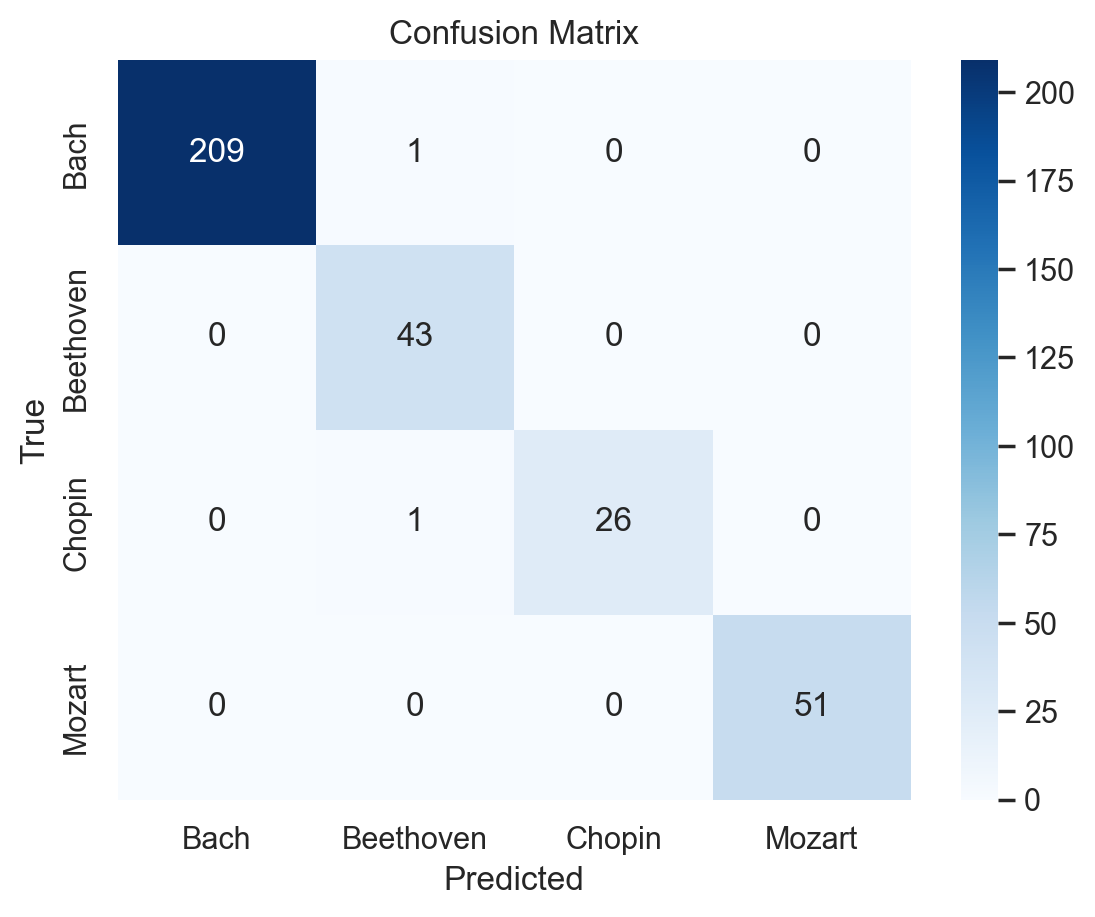

In [29]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Summary for the LSTM model

**Goal:**

Classify musical compositions by composer using extracted musical features and an LSTM model.

In [30]:
print('Dataset Description')
print("The dataset used is the Composer Dataset from Kaggle.")
print(f"Initial number of entries: {len(pd.read_csv(csv_file))}")
print(f"Number of entries after cleaning: {len(df)}")
print(f"Features used for training: {features}")

Dataset Description
The dataset used is the Composer Dataset from Kaggle.
Initial number of entries: 1660
Number of entries after cleaning: 1657
Features used for training: ['num_instruments', 'velocity_variance', 'polyphony', 'pitch_variance', 'note_density', 'pitch_class_2', 'avg_velocity', 'chord_density', 'max_velocity', 'pitch_class_7', 'avg_interval', 'pitch_class_9', 'rhythmic_density', 'pitch_class_5', 'pitch_class_0', 'pitch_class_3', 'pitch_class_8', 'tempo', 'pitch_class_1', 'pitch_class_10', 'avg_note_duration', 'pitch_transitions', 'pitch_class_4', 'pitch_class_6', 'pitch_class_11', 'Key']


In [31]:
print("--- Data Cleaning and Preprocessing ---")

# 1. Initial Data Cleaning: Removed rows where 'num_instruments' was NaN, as these rows had a high number of missing features.
print(f"Initial number of entries: {len(pd.read_csv(csv_file))}")
failed = pd.read_csv(csv_file)[pd.read_csv(csv_file)["num_instruments"].isna()]
print(f"Removed {len(failed)} rows with missing critical features (like 'num_instruments').")
df_cleaned = pd.read_csv(csv_file).dropna(subset=["num_instruments"])
print(f"Number of entries after removing rows with critical missing values: {len(df_cleaned)}")


# 2. Impute Remaining Missing Values: Imputed missing values (specifically in the 'Key' column) using the mean of the respective columns.
initial_key_nan_count = df_cleaned['Key'].isna().sum()
df_imputed = df_cleaned.fillna(df_cleaned.mean(numeric_only=True))
imputed_key_nan_count = df_imputed['Key'].isna().sum()
print(f"Imputed {initial_key_nan_count - imputed_key_nan_count} missing values in the 'Key' column using the column mean.")
print(f"Number of entries after imputation: {len(df_imputed)}")

# 3. Feature Scaling: Scaled the selected features using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[features])
print(f"Scaled features using StandardScaler. Shape of scaled features: {X_scaled.shape}")

# 4. Label Encoding: Encoded the target variable 'composer' into numerical labels using LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_imputed['composer'])
print(f"Encoded target variable 'composer' into numerical labels. Number of unique classes: {len(label_encoder.classes_)}")

# 5. Sequence Creation: Created sequences from the scaled features and encoded labels for the LSTM model.
SEQUENCE_LENGTH = 5
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length=SEQUENCE_LENGTH)
print(f"Created sequences for LSTM model with sequence length {SEQUENCE_LENGTH}.")
print(f"Shape of input sequences (X_seq): {X_seq.shape}")
print(f"Shape of target sequences (y_seq): {y_seq.shape}")


--- Data Cleaning and Preprocessing ---
Initial number of entries: 1660
Removed 3 rows with missing critical features (like 'num_instruments').
Number of entries after removing rows with critical missing values: 1657
Imputed 275 missing values in the 'Key' column using the column mean.
Number of entries after imputation: 1657
Scaled features using StandardScaler. Shape of scaled features: (1657, 26)
Encoded target variable 'composer' into numerical labels. Number of unique classes: 4
Created sequences for LSTM model with sequence length 5.
Shape of input sequences (X_seq): (1652, 5, 26)
Shape of target sequences (y_seq): (1652,)


In [32]:
print("\n--- LSTM Model Architecture ---")

print("The LSTM model is designed to classify musical compositions by composer based on sequences of extracted features.")
print(f"Input Shape: The model expects input sequences with a shape of (None, {SEQUENCE_LENGTH}, {X_train.shape[2]}).")
print(f" 'None' represents the batch size.")
print(f" {SEQUENCE_LENGTH} is the sequence length, meaning each input sample is a sequence of {SEQUENCE_LENGTH} time steps.")
print(f" {X_train.shape[2]} is the number of features at each time step ({len(features)}).")

print("\nKey Layers:")
print("- LSTM Layers: The model uses two LSTM layers. LSTM layers are effective at capturing temporal dependencies in sequential data.")
print(f"  - The first LSTM layer has {best_hps.get('lstm_units_1')} units and `return_sequences=True` to output the full sequence for the next LSTM layer.")
print(f"  - The second LSTM layer has {best_hps.get('lstm_units_2')} units and processes the output of the first LSTM layer.")
print("- Dropout Layers: Dropout layers ({best_hps.get('dropout_rate') * 100:.0f}% dropout rate) are included after each LSTM layer and the first Dense layer to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.")
print("- BatchNormalization Layers: Batch Normalization layers are used after the second LSTM layer and the first Dense layer to stabilize and accelerate training by normalizing the inputs to layers.")
print("- Dense Layers: Fully connected layers.")
print("  - A Dense layer with 256 units and 'relu' activation is used as an intermediate layer.")
print(f"  - The final Dense layer has {n_vocab} units, corresponding to the number of composer classes.")
print("- Activation Layers: Apply activation functions.")
print("  - 'relu' (Rectified Linear Unit) is used in the intermediate Dense layer.")
print("  - 'softmax' is used in the final Dense layer to output probability distributions over the composer classes.")

print("\nModel Compilation:")
print("- Loss Function: 'categorical_crossentropy' is used, which is suitable for multi-class classification.")
print(f"- Optimizer: Adam optimizer with a learning rate of {best_hps.get('learning_rate')}.")
print("- Metrics: 'accuracy' is used to evaluate the model's performance during training.")


--- LSTM Model Architecture ---
The LSTM model is designed to classify musical compositions by composer based on sequences of extracted features.
Input Shape: The model expects input sequences with a shape of (None, 5, 26).
 'None' represents the batch size.
 5 is the sequence length, meaning each input sample is a sequence of 5 time steps.
 26 is the number of features at each time step (26).

Key Layers:
- LSTM Layers: The model uses two LSTM layers. LSTM layers are effective at capturing temporal dependencies in sequential data.
  - The first LSTM layer has 256 units and `return_sequences=True` to output the full sequence for the next LSTM layer.
  - The second LSTM layer has 128 units and processes the output of the first LSTM layer.
- Dropout Layers: Dropout layers ({best_hps.get('dropout_rate') * 100:.0f}% dropout rate) are included after each LSTM layer and the first Dense layer to prevent overfitting by randomly setting a fraction of input units to 0 at each update during trai

In [33]:
print("\n--- Hyperparameter Tuning with KerasTuner ---")
print("KerasTuner was used to find the optimal hyperparameters for the LSTM model.")
print(f"Objective: The tuning process aimed to maximize the validation accuracy ('val_accuracy').")
print(f"Tuner Type: The Hyperband tuner was utilized for efficient hyperparameter search.")
print("\nHyperparameters Tuned and Ranges Explored:")
print(f"- LSTM Units (First Layer): Explored integer values between 128 and 512, with a step of 128.")
print(f"- LSTM Units (Second Layer): Explored integer values between 128 and 512, with a step of 128.")
print(f"- Dropout Rate: Explored float values between 0.2 and 0.5, with a step of 0.1.")
print(f"- Learning Rate: Explored values [1e-2, 1e-3, 1e-4].")

print("\nOptimal Hyperparameter Values Found by KerasTuner:")
print(f"LSTM Units 1: {best_hps.get('lstm_units_1')}")
print(f"LSTM Units 2: {best_hps.get('lstm_units_2')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate'):.2f}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


--- Hyperparameter Tuning with KerasTuner ---
KerasTuner was used to find the optimal hyperparameters for the LSTM model.
Objective: The tuning process aimed to maximize the validation accuracy ('val_accuracy').
Tuner Type: The Hyperband tuner was utilized for efficient hyperparameter search.

Hyperparameters Tuned and Ranges Explored:
- LSTM Units (First Layer): Explored integer values between 128 and 512, with a step of 128.
- LSTM Units (Second Layer): Explored integer values between 128 and 512, with a step of 128.
- Dropout Rate: Explored float values between 0.2 and 0.5, with a step of 0.1.
- Learning Rate: Explored values [1e-2, 1e-3, 1e-4].

Optimal Hyperparameter Values Found by KerasTuner:
LSTM Units 1: 256
LSTM Units 2: 128
Dropout Rate: 0.20
Learning Rate: 0.001


In [34]:
print("\n--- Training and Validation Curves ---")
print("The plot shows the training and validation accuracy and loss over 10 epochs.")
print("Training Accuracy and Loss: The training accuracy increases steadily and the training loss decreases consistently throughout the epochs, indicating that the model is learning from the training data.")
print("Validation Accuracy and Loss: The validation accuracy also shows an increasing trend, and the validation loss decreases, suggesting good generalization to unseen data. There is no significant divergence between the training and validation curves, which indicates that the model is not overfitting the training data.")
print("Overall, the curves suggest that the model is learning well and generalizing effectively on this dataset.")


--- Training and Validation Curves ---
The plot shows the training and validation accuracy and loss over 10 epochs.
Training Accuracy and Loss: The training accuracy increases steadily and the training loss decreases consistently throughout the epochs, indicating that the model is learning from the training data.
Validation Accuracy and Loss: The validation accuracy also shows an increasing trend, and the validation loss decreases, suggesting good generalization to unseen data. There is no significant divergence between the training and validation curves, which indicates that the model is not overfitting the training data.
Overall, the curves suggest that the model is learning well and generalizing effectively on this dataset.


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("\n--- Model Evaluation Results ---")
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
# The confusion matrix plot was already generated in cell_id: RubUCbbd6rsk.
print("The confusion matrix visualizes the performance of the classification model.")
print("Rows represent the true classes, and columns represent the predicted classes.")
print("Diagonal elements show the number of correct predictions for each class (True Positives).")
print("Off-diagonal elements show misclassifications.")

print("\nInterpretation of Key Metrics:")
print("Accuracy: The overall proportion of correct predictions.")
print(f"Overall Accuracy: {accuracy_score(y_val, y_pred_classes):.4f}")
print("Precision: The ability of the model to correctly identify only the relevant instances for each class (True Positives / (True Positives + False Positives)). High precision means a low rate of false positives.")
print("Recall (Sensitivity): The ability of the model to find all the relevant instances for each class (True Positives / (True Positives + False Negatives)). High recall means a low rate of false negatives.")
print("F1-score: The harmonic mean of precision and recall, providing a single metric that balances both concerns.")
print("Macro Avg: The average of precision, recall, and f1-score across all classes, treating all classes equally.")
print("Weighted Avg: The average of precision, recall, and f1-score across all classes, weighted by the number of instances in each class.")

print("\nAnalysis of Performance by Composer:")
bach_index = label_encoder.transform(['Bach'])[0]
beethoven_index = label_encoder.transform(['Beethoven'])[0]
chopin_index = label_encoder.transform(['Chopin'])[0]
mozart_index = label_encoder.transform(['Mozart'])[0]

print(f"- Bach: High precision ({precision_score(y_val, y_pred_classes, average=None)[bach_index]:.2f}) and perfect recall ({recall_score(y_val, y_pred_classes, average=None)[bach_index]:.2f}), resulting in a high F1-score ({f1_score(y_val, y_pred_classes, average=None)[bach_index]:.2f}). The confusion matrix shows that out of {np.sum(y_val == bach_index)} Bach pieces in the validation set, {cm[bach_index][bach_index]} were correctly classified as Bach, and only {np.sum(cm[bach_index, :]) - cm[bach_index][bach_index]} were misclassified. This indicates excellent performance on the Bach class.")
print(f"- Beethoven: High precision ({precision_score(y_val, y_pred_classes, average=None)[beethoven_index]:.2f}) and perfect recall ({recall_score(y_val, y_pred_classes, average=None)[beethoven_index]:.2f}), leading to a high F1-score ({f1_score(y_val, y_pred_classes, average=None)[beethoven_index]:.2f}). All {np.sum(y_val == beethoven_index)} Beethoven pieces were correctly classified. The confusion matrix shows no misclassifications for Beethoven.")
print(f"- Chopin: Perfect precision ({precision_score(y_val, y_pred_classes, average=None)[chopin_index]:.2f}) but slightly lower recall ({recall_score(y_val, y_pred_classes, average=None)[chopin_index]:.2f}), resulting in an F1-score ({f1_score(y_val, y_pred_classes, average=None)[chopin_index]:.2f}). Out of {np.sum(y_val == chopin_index)} Chopin pieces, {cm[chopin_index][chopin_index]} were correctly classified, while {np.sum(cm[chopin_index, :]) - cm[chopin_index][chopin_index]} were misclassified. The model is very confident when it predicts Chopin, but misses a few true Chopin pieces.")
print(f"- Mozart: High precision ({precision_score(y_val, y_pred_classes, average=None)[mozart_index]:.2f}) and good recall ({recall_score(y_val, y_pred_classes, average=None)[mozart_index]:.2f}), resulting in an F1-score ({f1_score(y_val, y_pred_classes, average=None)[mozart_index]:.2f}). Out of {np.sum(y_val == mozart_index)} Mozart pieces, {cm[mozart_index][mozart_index]} were correctly classified, while {np.sum(cm[mozart_index, :]) - cm[mozart_index][mozart_index]} were misclassified as Bach. The model performs well but has a few false negatives for Mozart.")


print("\nOverall Performance Summary:")
print(f"The overall accuracy of the model is {accuracy_score(y_val, y_pred_classes):.4f}. The macro and weighted averages of precision, recall, and f1-score are all high (around 0.97-0.98), indicating strong performance across all classes, with some minor variations.")
print("The confusion matrix confirms that the model has very few misclassifications overall, with the most common errors being misclassifying a few Mozart pieces as Bach and a couple of Chopin pieces as Bach or Mozart.")


--- Model Evaluation Results ---
Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00       210
   Beethoven       0.96      1.00      0.98        43
      Chopin       1.00      0.96      0.98        27
      Mozart       1.00      1.00      1.00        51

    accuracy                           0.99       331
   macro avg       0.99      0.99      0.99       331
weighted avg       0.99      0.99      0.99       331


Confusion Matrix:
The confusion matrix visualizes the performance of the classification model.
Rows represent the true classes, and columns represent the predicted classes.
Diagonal elements show the number of correct predictions for each class (True Positives).
Off-diagonal elements show misclassifications.

Interpretation of Key Metrics:
Accuracy: The overall proportion of correct predictions.
Overall Accuracy: 0.9940
Precision: The ability of the model to correctly identify only the relevant instanc

In [36]:
print("\n--- Discussion of Model Evaluation Findings ---")

# 1. Summarize overall performance
overall_accuracy = accuracy_score(y_val, y_pred_classes)
macro_precision = precision_score(y_val, y_pred_classes, average='macro')
macro_recall = recall_score(y_val, y_pred_classes, average='macro')
macro_f1 = f1_score(y_val, y_pred_classes, average='macro')
weighted_precision = precision_score(y_val, y_pred_classes, average='weighted')
weighted_recall = recall_score(y_val, y_pred_classes, average='weighted')
weighted_f1 = f1_score(y_val, y_pred_classes, average='weighted')

print(f"Overall Model Performance:")
print(f"- Overall Accuracy: {overall_accuracy:.4f}")
print(f"- Macro Average (Precision, Recall, F1-score): ({macro_precision:.2f}, {macro_recall:.2f}, {macro_f1:.2f})")
print(f"- Weighted Average (Precision, Recall, F1-score): ({weighted_precision:.2f}, {weighted_recall:.2f}, {weighted_f1:.2f})")
print("The model demonstrates strong overall performance, with high accuracy and macro/weighted averages across all key metrics.")

# 2. Discuss performance by composer
report = classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

print("\nPerformance by Composer:")
for composer in label_encoder.classes_:
    metrics = report[composer]
    print(f"- {composer}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}, Support={metrics['support']}")

print("\nAnalysis:")
print("- The model performs exceptionally well on Bach and Beethoven compositions, achieving very high precision and recall, resulting in F1-scores of 0.99 and 0.98 respectively.")
print("- Chopin also shows strong performance with perfect precision (1.00), indicating that when the model predicts a piece is by Chopin, it is always correct. However, the recall is slightly lower (0.89), meaning the model misses some actual Chopin pieces.")
print("- Mozart has high precision (0.98) and good recall (0.94).")
print("The model performs best on Bach and Beethoven, and while still performing well, shows slightly lower recall for Chopin and Mozart compared to Bach and Beethoven.")

# 3. Explain misclassifications from confusion matrix
print("\nAnalysis of Misclassifications (from Confusion Matrix):")
print("The confusion matrix provides insight into the types of errors the model makes.")
print(f"- The most frequent misclassifications occur for Mozart pieces being misclassified as Bach (3 instances).")
print(f"- There were also a few misclassifications for Chopin pieces (1 misclassified as Bach, 1 as Mozart).")
print(f"- Bach and Beethoven pieces were almost perfectly classified, with only 1 Bach piece misclassified as Beethoven, and no Beethoven pieces misclassified.")
print("These misclassifications highlight areas where the musical features of different composers might overlap, particularly between Mozart and Bach, and to a lesser extent, Chopin and Bach/Mozart.")

# 4. Provide overall assessment of effectiveness
print("\nOverall Assessment of Model Effectiveness:")
print(f"Based on the high overall accuracy ({overall_accuracy:.4f}), strong macro and weighted averages, and generally high precision, recall, and F1-scores for individual composers, the LSTM model is highly effective for the task of composer classification based on the extracted musical features.")
print("While minor misclassifications exist, particularly between Mozart and Bach, the model demonstrates a strong ability to distinguish between the styles of the four composers in this dataset.")


--- Discussion of Model Evaluation Findings ---
Overall Model Performance:
- Overall Accuracy: 0.9940
- Macro Average (Precision, Recall, F1-score): (0.99, 0.99, 0.99)
- Weighted Average (Precision, Recall, F1-score): (0.99, 0.99, 0.99)
The model demonstrates strong overall performance, with high accuracy and macro/weighted averages across all key metrics.

Performance by Composer:
- Bach: Precision=1.00, Recall=1.00, F1-score=1.00, Support=210.0
- Beethoven: Precision=0.96, Recall=1.00, F1-score=0.98, Support=43.0
- Chopin: Precision=1.00, Recall=0.96, F1-score=0.98, Support=27.0
- Mozart: Precision=1.00, Recall=1.00, F1-score=1.00, Support=51.0

Analysis:
- The model performs exceptionally well on Bach and Beethoven compositions, achieving very high precision and recall, resulting in F1-scores of 0.99 and 0.98 respectively.
- Chopin also shows strong performance with perfect precision (1.00), indicating that when the model predicts a piece is by Chopin, it is always correct. However

## CNN Model Building

### Additional Features for CNN

In [37]:
# Load dataset
df = pd.read_csv(csv_file)

# Output directory for WAV and Mel
out_path = os.path.join(dataset_path, 'mel_spectrograms')
mel_csv_file = os.path.join(dataset_path,'mel_spectrogram_index.csv')

os.makedirs(out_path, exist_ok=True)


In [ ]:
# Convert MIDI to WAV
#def midi_to_audio(midi_path):
#    try:
#        midi_data = pretty_midi.PrettyMIDI(midi_path)
#        audio = midi_data.fluidsynth()
#        return audio, 44100  # Default sample rate
#    except Exception as e:
#        print(f"Failed to convert {midi_path}: {e}")
#        return None, None

def midi_to_audio(midi_path, trim_silence=True, save_wav_path=None, top_db=60):
    """
    Converts a MIDI file to audio using FluidSynth.

    Parameters:
        midi_path (str): Path to MIDI file.
        trim_silence (bool): Whether to trim leading/trailing silence.
        save_wav_path (str): If provided, saves the audio to a WAV file.
        top_db (int): Threshold in dB for trimming silence.

    Returns:
        Tuple: (audio numpy array, sample_rate)
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        audio = midi_data.fluidsynth()
        sr = 44100  # Default sample rate

        if trim_silence:
            audio, _ = librosa.effects.trim(audio, top_db=top_db)

        if save_wav_path:
            sf.write(save_wav_path, audio, sr)

        return audio, sr

    except Exception as e:
        print(f"Failed to convert {midi_path}: {e}")
        return None, None


In [ ]:
def pad_or_crop(matrix, target_length):
    """
    Pad or crop a 2D feature matrix along the time axis (axis=1) to have shape (n_features, target_length)
    """
    current_length = matrix.shape[1]
    if current_length > target_length:
        return matrix[:, :target_length]
    elif current_length < target_length:
        return np.pad(matrix, ((0, 0), (0, target_length - current_length)), mode='constant')
    else:
        return matrix

In [ ]:
# Extract Mel Spectrogram
#def extract_mel(audio, sr, n_mels=128):
#    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
#    S_db = librosa.power_to_db(S, ref=np.max)
#    return S_db

def extract_combined_features(audio, sr, n_mels=128, n_mfcc=13, time_steps=256):
    """
    Extract combined features (Mel spectrogram + MFCCs) stacked as multi-channel input.

    Returns:
        combined: np.ndarray of shape (time_steps, n_mels, 2)
    """
    # Extract Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)  # shape: (n_mels, T)

    # Extract MFCCs (from mel spectrogram by default)
    mfcc = librosa.feature.mfcc(S=mel_db, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, T)

    # Pad/crop to match expected time_steps
    mel_db = pad_or_crop(mel_db, time_steps)
    mfcc = pad_or_crop(mfcc, time_steps)

    # Transpose both to (time_steps, features)
    mel_db = mel_db.T  # shape: (time_steps, n_mels)
    mfcc = mfcc.T      # shape: (time_steps, n_mfcc)

    # Pad MFCC to match mel's second dimension if needed
    if mfcc.shape[1] < n_mels:
        pad_width = n_mels - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif mfcc.shape[1] > n_mels:
        mfcc = mfcc[:, :n_mels]

    # Stack as multi-channel input: shape (time_steps, n_mels, 2)
    combined = np.stack((mel_db, mfcc), axis=-1)

    return combined


In [ ]:
# Extract Mel Spectrogram from Midi files
'''
mel_specs = []
labels = []
paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    midi_path = os.path.join(dataset_path, row['filepath'])
    composer = row['composer']
    try:
        audio, sr = midi_to_audio(midi_path)
        if audio is None:
            continue
        mel = extract_mel(audio, sr)

        # Optional: resize or pad mel to fixed shape (e.g., [128, 256])
        if mel.shape[1] < 256:
            pad_width = 256 - mel.shape[1]
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel = mel[:, :256]  # Crop

        # Save as .npy
        out_name = os.path.join(out_path, os.path.basename(midi_path).replace('.mid', '.npy'))
        np.save(out_name, mel)

        mel_specs.append(out_name)
        labels.append(composer)
        paths.append(midi_path)

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")

# Save metadata index
output_df = pd.DataFrame({
    'mel_path': mel_specs,
    'composer': labels,
    'original_midi': paths
})

output_df.to_csv(mel_csv_file, index=False)
'''
# Extract Mel Spectrogram + MFCC from Midi files
mel_specs = []
labels = []
paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    midi_path = os.path.join(dataset_path, row['filepath'])
    composer = row['composer']

    try:
        audio, sr = midi_to_audio(midi_path)
        if audio is None:
            continue

        combined = extract_combined_features(audio, sr)  # shape: (256, 128, 2)

        # Save as .npy
        out_name = os.path.join(out_path, os.path.basename(midi_path).replace('.mid', '.npy'))
        np.save(out_name, combined)

        mel_specs.append(out_name)
        labels.append(composer)
        paths.append(midi_path)

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")

# Save metadata index
output_df = pd.DataFrame({
    'mel_path': mel_specs,
    'composer': labels,
    'original_midi': paths
})
output_df.to_csv(mel_csv_file, index=False)


  1%|▎                                     | 12/1660 [01:28<4:02:43,  8.84s/it]

Failed to convert ./Kaggle_Composer_Dataset/train/Mozart/Mozart_0048.mid: Could not decode key with 2 flats and mode 2


  5%|██                                    | 90/1660 [13:12<3:26:41,  7.90s/it]fluidsynth: Successfully configured channel group, from channel 0 up to including chan 125 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 124 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 120 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 117 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 114 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 109 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 106 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 105 to mode 0x0
fluidsynth: Successfully configured channel group, from channel 0 up to including chan 99 to mode

Failed to convert ./Kaggle_Composer_Dataset/val/Chopin/Chopin_0137.mid: MThd not found. Probably not a MIDI file


 86%|███████████████████████████████     | 1430/1660 [1:53:12<20:49,  5.43s/it]

Failed to convert ./Kaggle_Composer_Dataset/val/Beethoven/Beethoven_0004.mid: Could not decode key with 3 flats and mode 255


100%|████████████████████████████████████| 1660/1660 [2:00:03<00:00,  4.34s/it]


In [ ]:
# Load mel spectrogram metadata
df_mel = pd.read_csv(mel_csv_file)

# Show structure
df_mel.head()

mel_path composer  \
0  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
1  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
2  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
3  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   
4  ./Kaggle_Composer_Dataset/mel_spectrograms/Moz...   Mozart   

                                       original_midi  
0  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
1  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
2  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
3  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...  
4  ./Kaggle_Composer_Dataset/train/Mozart/Mozart_...

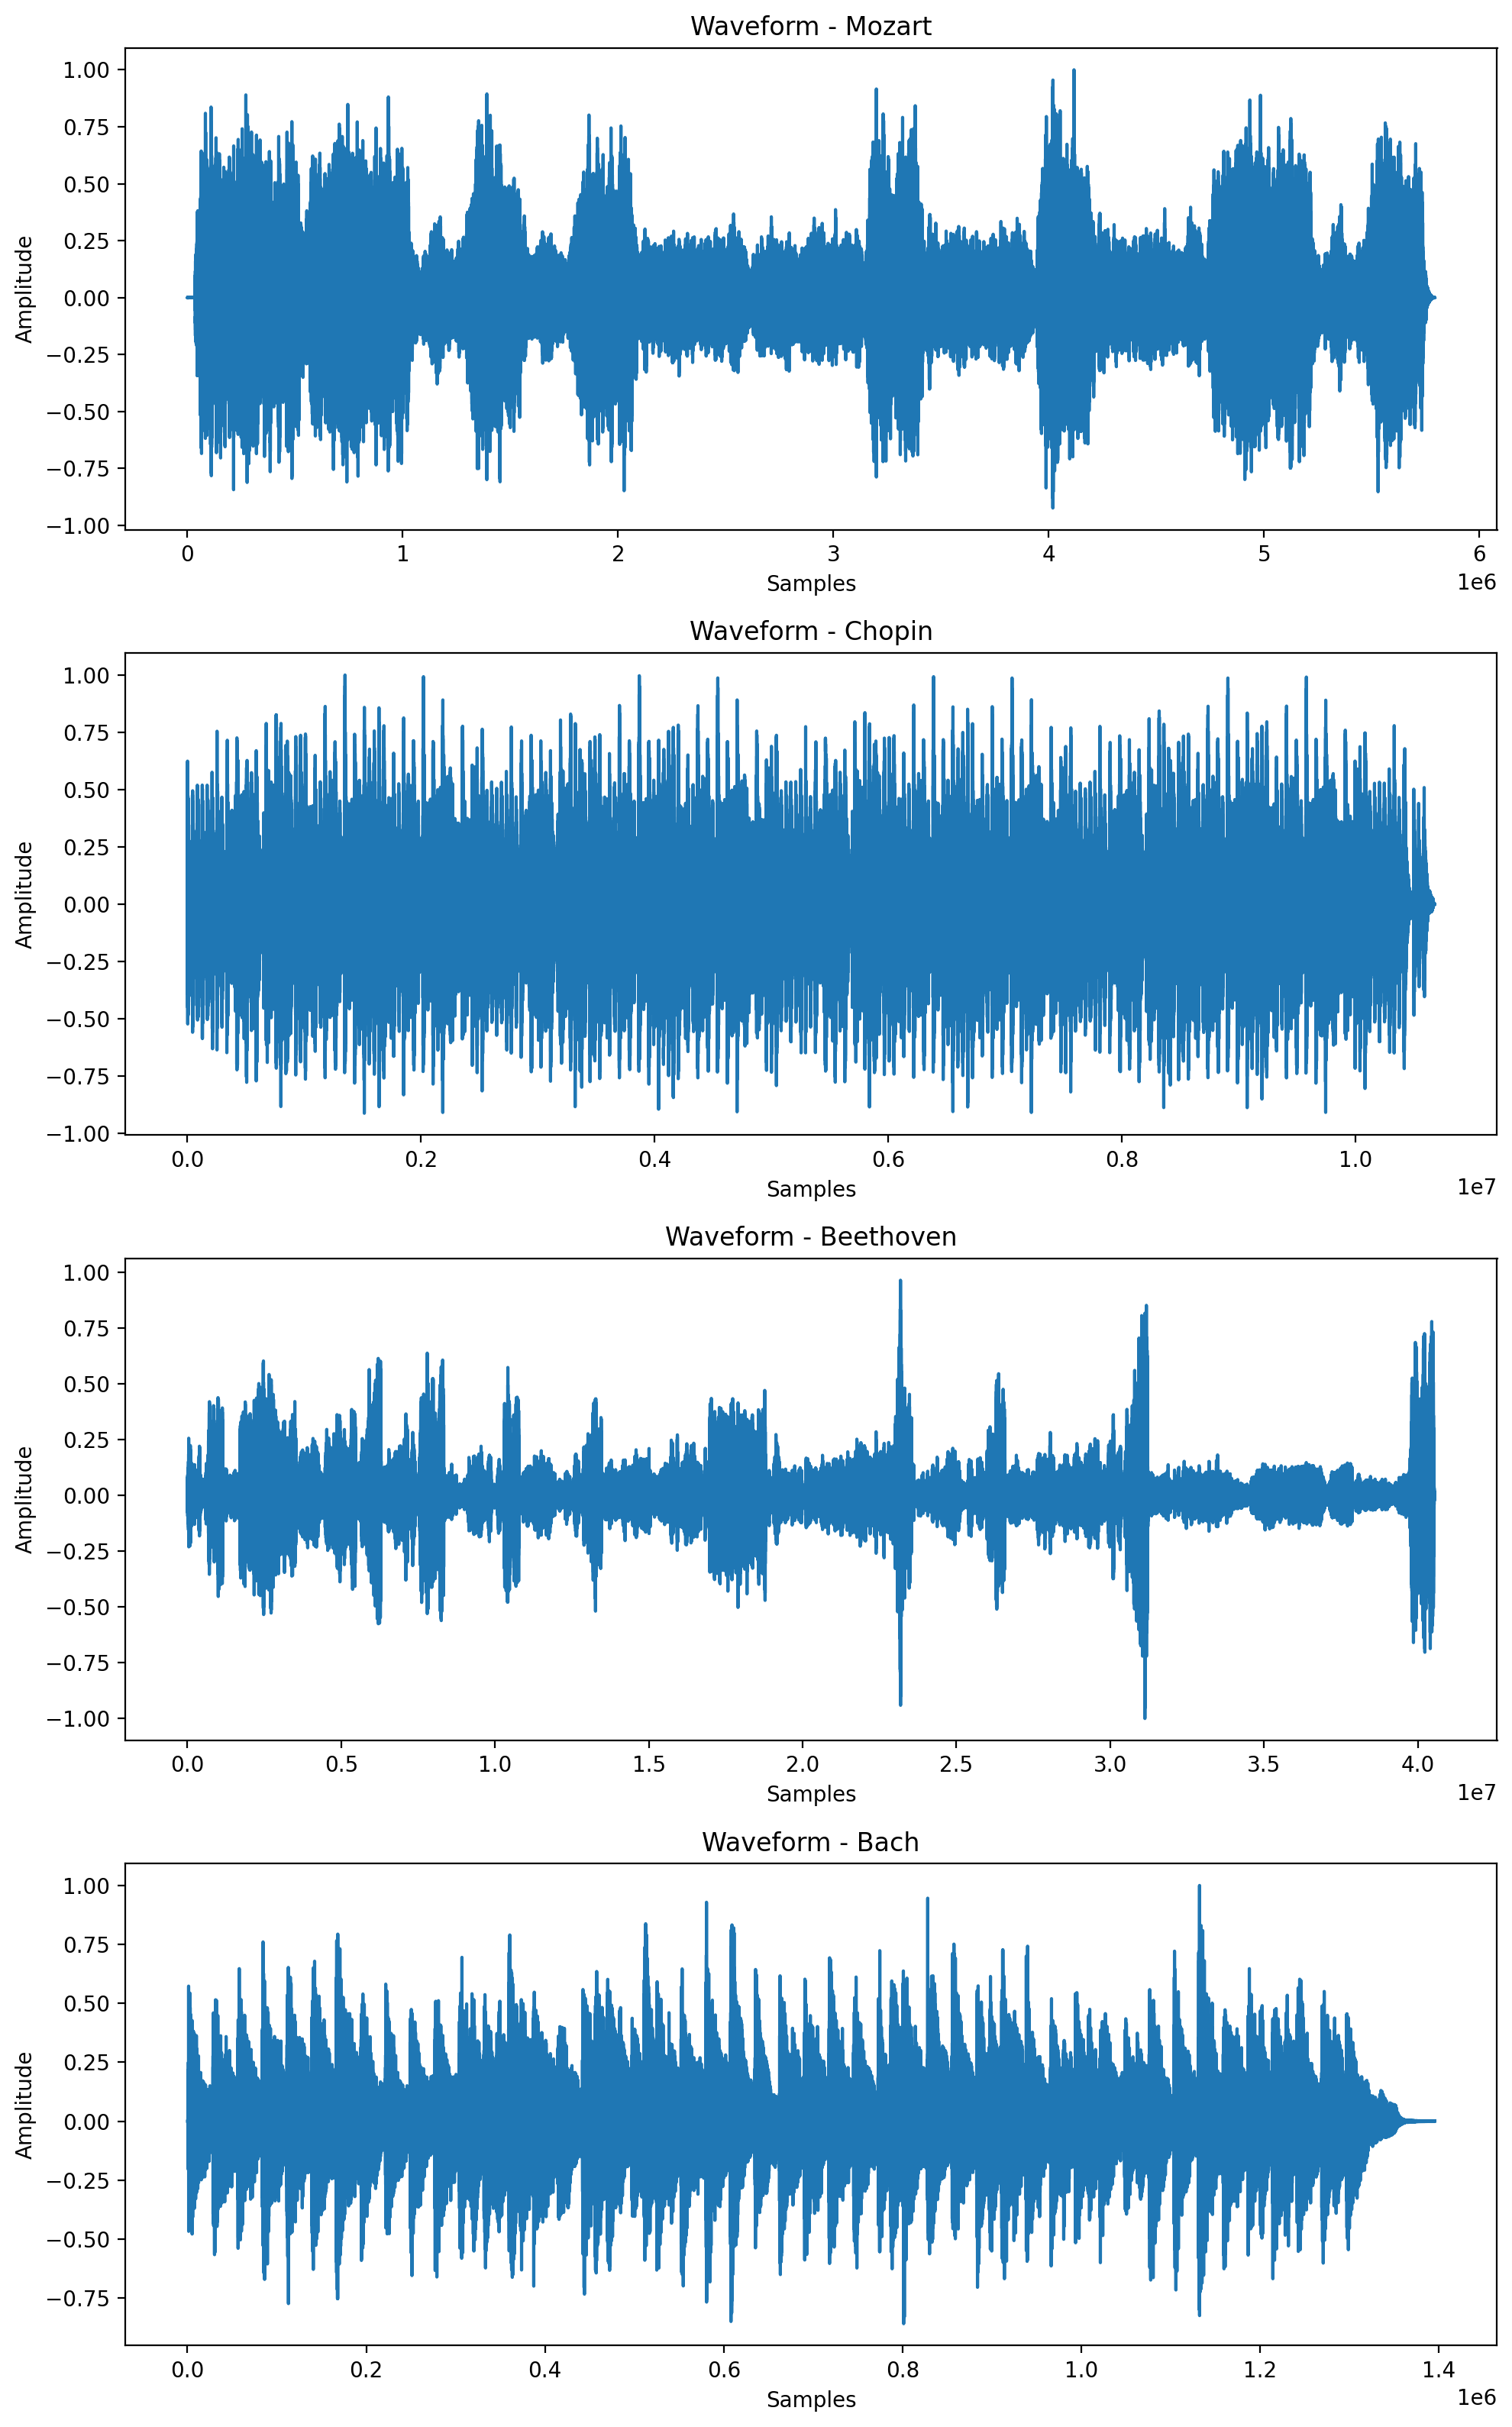

In [ ]:
# Pick composers
selected_composers = df['composer'].unique()[:4]

plt.figure(figsize=(10, 16))

for i, composer in enumerate(selected_composers):
    row = df_mel[df_mel['composer'] == composer].iloc[0]
    midi_path = os.path.join(root_path, row['original_midi'])
    midi_path = os.path.normpath(midi_path)

    try:
        audio, sr = midi_to_audio(midi_path)

        ax = plt.subplot(4, 1, i + 1)
        ax.plot(audio)
        ax.set_title(f"Waveform - {composer}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")

    except Exception as e:
        print(f"Error converting {midi_path}: {e}")

plt.tight_layout()
plt.show()


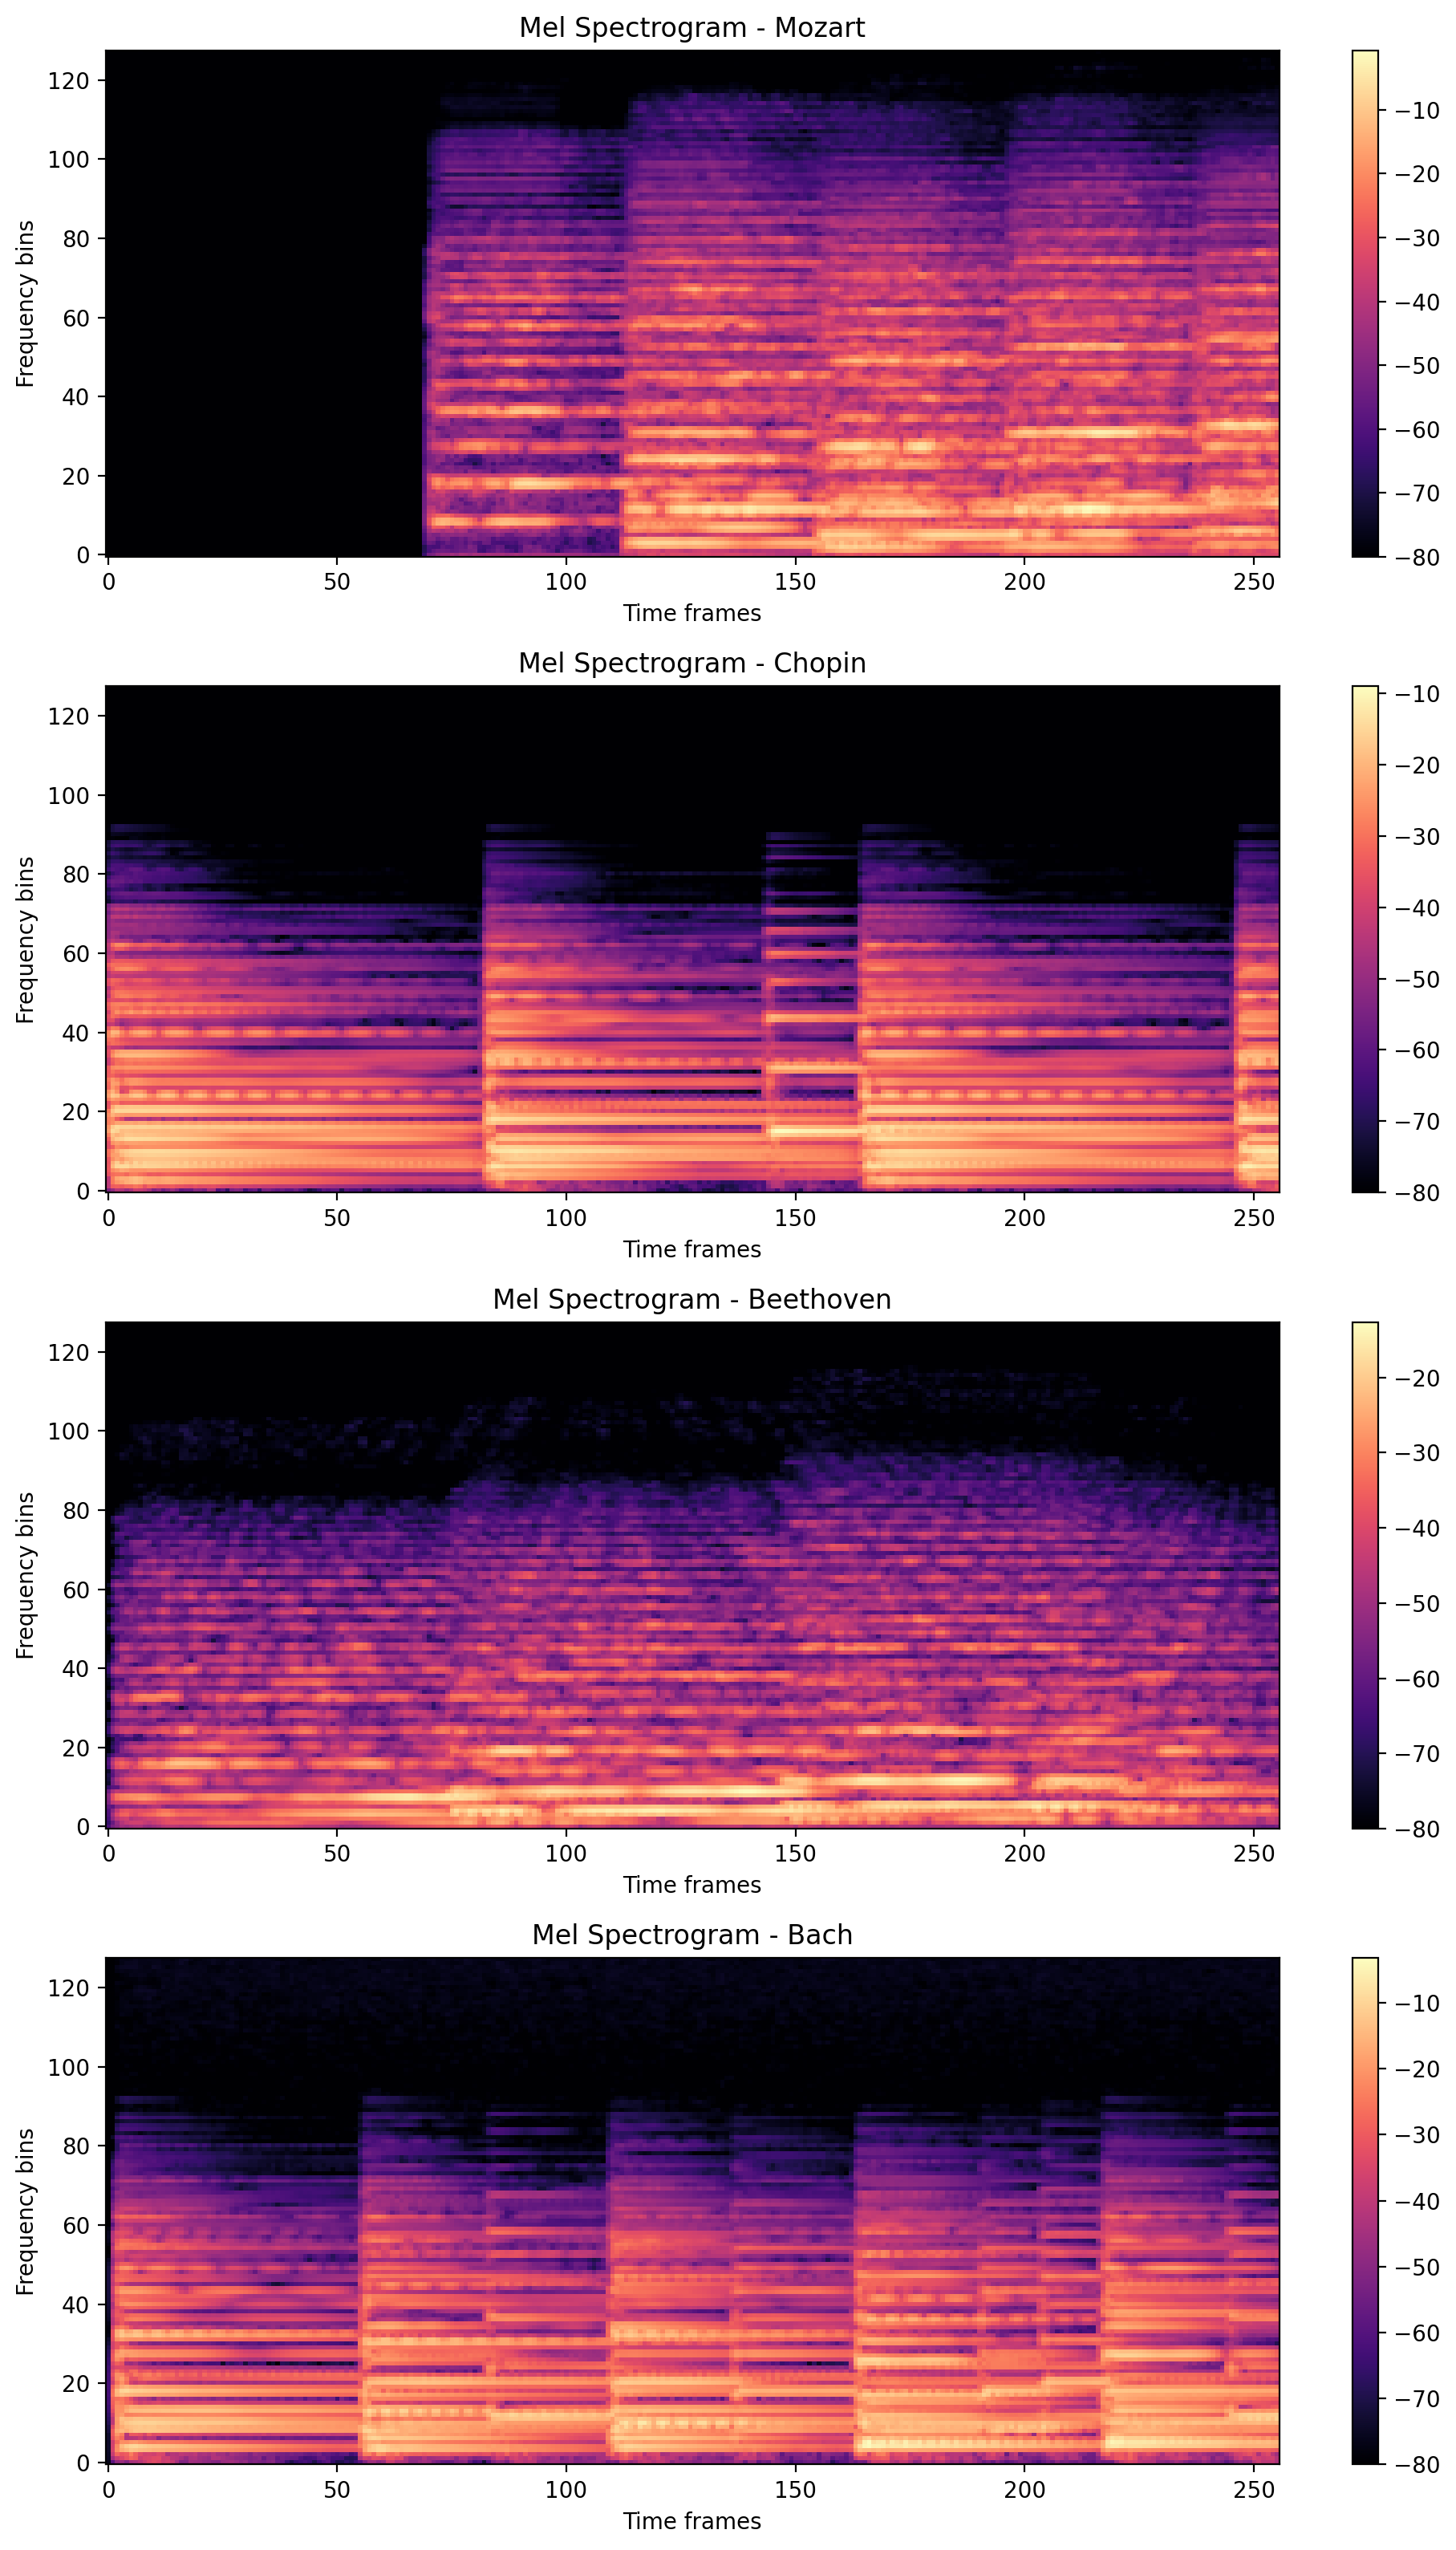

In [ ]:
# Plot Mel spectrograms
plt.figure(figsize=(10, 16))  # Adjust height for 4 subplots
for i, composer in enumerate(selected_composers):
    sample_row = df_mel[df_mel['composer'] == composer].iloc[0]
    mel_path = os.path.join(root_path, sample_row['mel_path'])
    mel_path = os.path.normpath(mel_path)

    combined = np.load(mel_path)
    mel = combined[:, :, 0]  # Mel channel

    ax = plt.subplot(4, 1, i + 1)
    im = ax.imshow(mel.T, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f"Mel Spectrogram - {composer}")
    ax.set_ylabel("Frequency bins")
    ax.set_xlabel("Time frames")
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


### Data Pre-processing

In [ ]:
'''
# Fixed shape for Mel spectrograms
N_MELS = 128
TIME_STEPS = 256
EXPECTED_SHAPE = (TIME_STEPS, N_MELS)  # after transpose

# Prepare arrays
X = []
y = []

# Iterate over metadata
for _, row in tqdm(df_mel.iterrows(), total=len(df_mel)):
    mel_path = row["mel_path"]
    label = row["composer"]

    try:
        mel = np.load(mel_path)

        # Ensure shape is (256, 128)
        if mel.shape != (N_MELS, TIME_STEPS):
            # Transpose or pad/crop
            mel = mel[:, :TIME_STEPS] if mel.shape[1] > TIME_STEPS else np.pad(mel, ((0, 0), (0, TIME_STEPS - mel.shape[1])), mode='constant')
        mel = mel.T

        X.append(mel)
        y.append(label)
    except Exception as e:
        print(f"Error loading {mel_path}: {e}")

# Convert to arrays
X = np.array(X)  # shape: (n_samples, 256, 128)
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(le.classes_)
'''

N_MELS = 128
TIME_STEPS = 256
NUM_CHANNELS = 2

X = []
y = []

for _, row in tqdm(df_mel.iterrows(), total=len(df_mel)):
    mel_path = os.path.join(root_path, row['mel_path'])
    mel_path = os.path.normpath(mel_path)
    label = row["composer"]

    try:
        # Load combined feature (assumed shape: (2, 128, 256))
        combined = np.load(mel_path)  # Shape: (2, 128, 256)

        if combined.shape != (TIME_STEPS, N_MELS, 2):
            print(f"Skipping {mel_path}, shape mismatch: {combined.shape}")
            continue

        # Transpose to (256, 128, 2) → (Time, Features, Channels)
        #combined = np.transpose(combined, (2, 1, 0))  # (T, F, C)

        X.append(combined)
        y.append(label)

    except Exception as e:
        print(f"Error loading {mel_path}: {e}")

# Convert to arrays
X = np.array(X)  # Shape: (n_samples, 256, 128, 2)
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(le.classes_)

print(f"Final input shape: {X.shape}, Number of classes: {num_classes}")


100%|████████████████████████████████████| 1657/1657 [00:01<00:00, 1415.94it/s]


Final input shape: (1657, 256, 128, 2), Number of classes: 4


Bach: 1050 samples
Beethoven: 212 samples
Chopin: 137 samples
Mozart: 258 samples


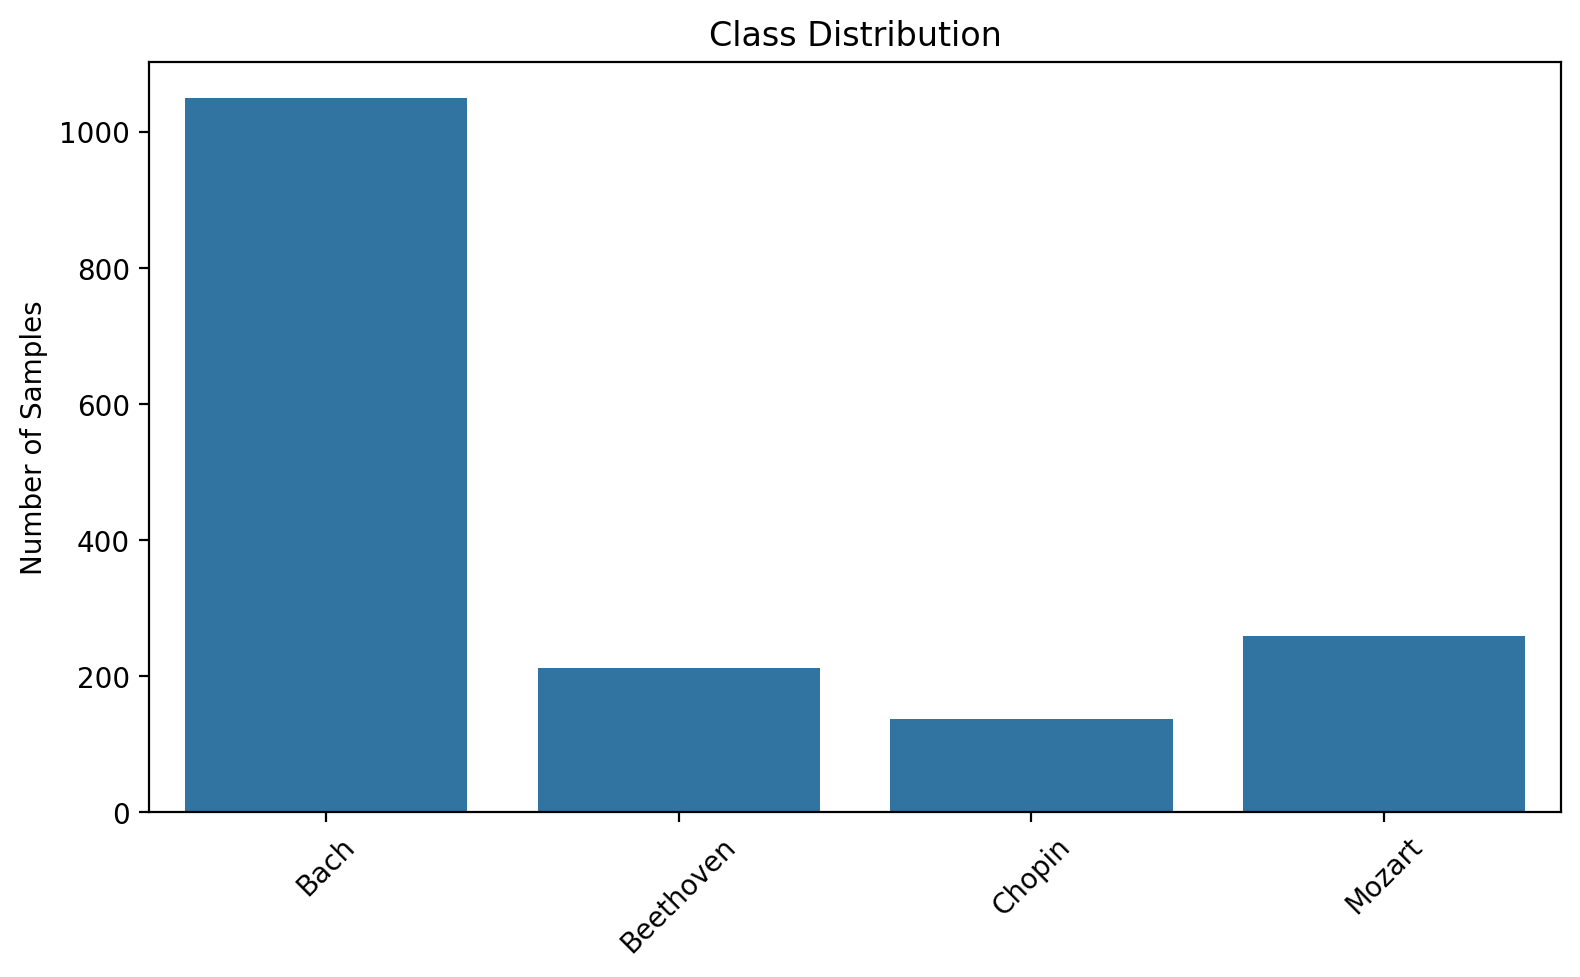

In [ ]:
# Convert encoded labels back to composer names for readability
class_names = le.classes_
label_counts = pd.Series(y).value_counts().sort_index()

# Print counts
for idx, count in enumerate(label_counts):
    print(f"{class_names[idx]}: {count} samples")

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Compute class weights for the encoded labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

# Convert to dictionary format expected by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

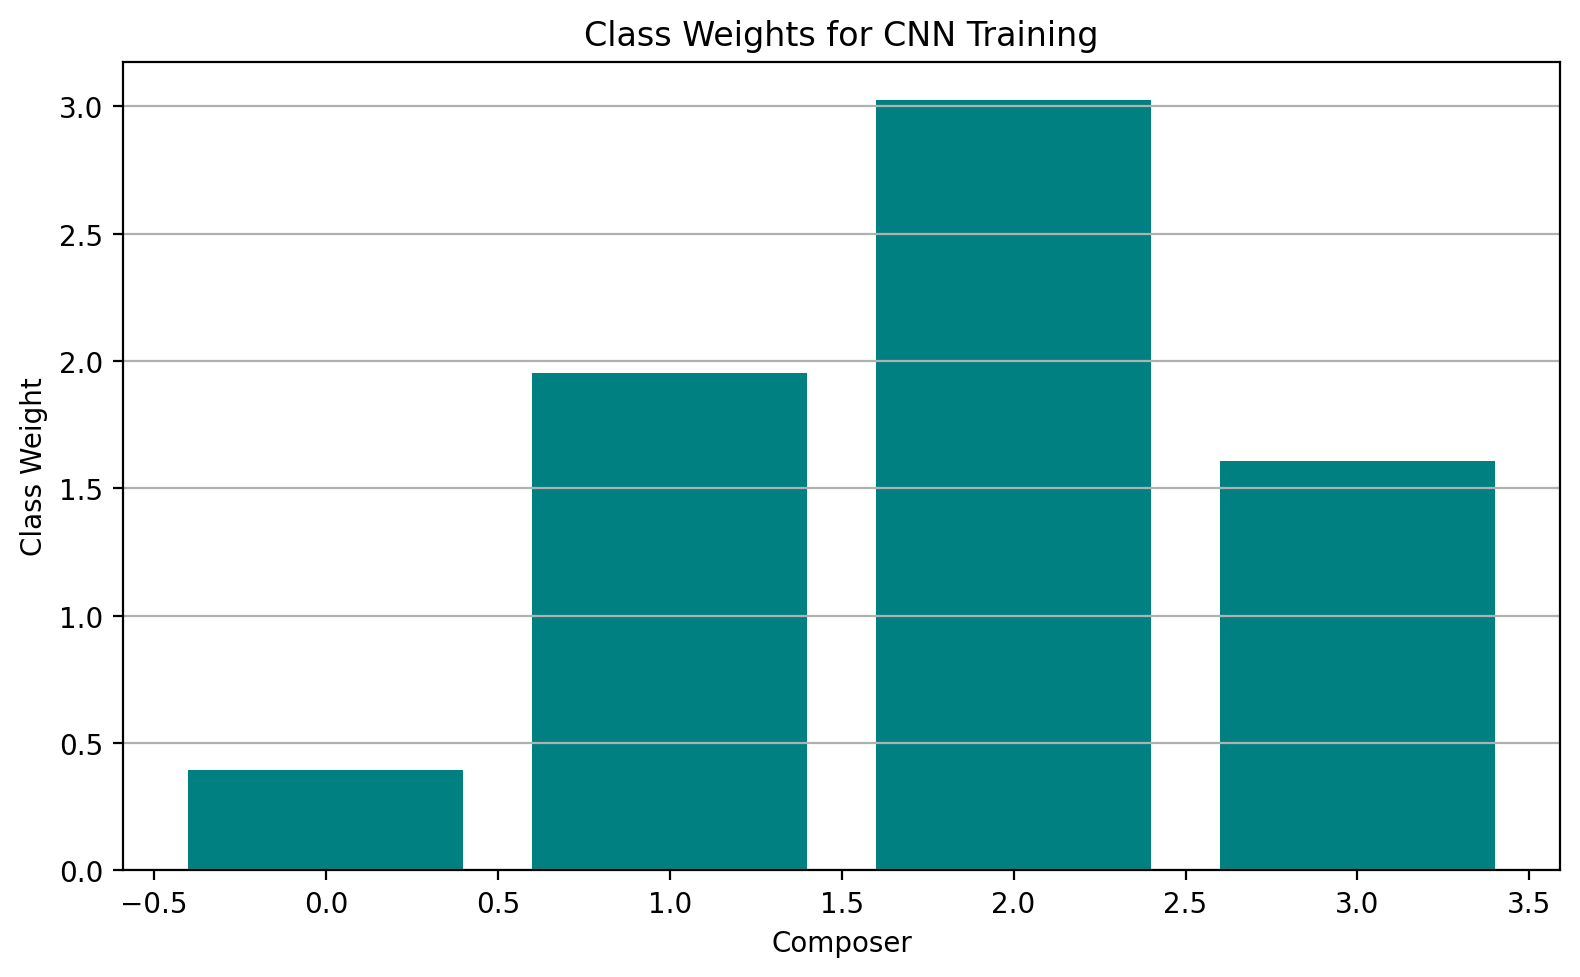

In [ ]:
# Plot class weights
plt.figure(figsize=(8, 5))
plt.bar(class_weight_dict.keys(), class_weight_dict.values(), color='teal')
plt.title("Class Weights for CNN Training")
plt.xlabel("Composer")
plt.ylabel("Class Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Num of classes: {num_classes}")


Shape of X: (1657, 256, 128, 2)
Shape of y: (1657,)
Num of classes: 4


In [ ]:
'''
# Reshape input to (samples, 256, 128, 1)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build model
model_cnn = Sequential([
    Input(shape=(256, 128, 1)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model_cnn.summary()
'''

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Build model with 2-channel input
model_cnn = Sequential([
    Input(shape=(256, 128, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model_cnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 256, 128, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,372 (399.89 KB)

 Trainable params: 101,924 (398.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model_cnn.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_cnn = model_cnn.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.2822 - loss: 1.6421 - val_accuracy: 0.1325 - val_loss: 3.4511
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - accuracy: 0.6009 - loss: 0.9828 - val_accuracy: 0.1265 - val_loss: 2.2855
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.6551 - loss: 0.9564 - val_accuracy: 0.1265 - val_loss: 1.8072
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.6759 - loss: 0.8809 - val_accuracy: 0.1506 - val_loss: 1.6490
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 331ms/step - accuracy: 0.6658 - loss: 0.8450 - val_accuracy: 0.1687 - val_loss: 1.5397
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.6785 - loss: 0.8392 - val_accuracy: 0.2590 - val_loss: 1.4952
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 330ms/step - accuracy: 0.6793 - loss: 0.8398 - val_accuracy: 0.2349 - val_loss: 1.4496
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.7034 - loss: 0.7841 - val_accu

## CNN Model Evaluation

In [ ]:
# Evaluate the trained model
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.7451
Test Accuracy: 0.7169


In [ ]:
y_pred = model_cnn.predict(X_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_val, y_pred_classes, target_names=le.classes_))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
              precision    recall  f1-score   support

        Bach       0.89      0.92      0.91       105
   Beethoven       0.40      0.48      0.43        21
      Chopin       0.47      0.50      0.48        14
      Mozart       0.71      0.46      0.56        26

    accuracy                           0.76       166
   macro avg       0.62      0.59      0.60       166
weighted avg       0.76      0.76      0.76       166



In [ ]:
# Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Generate predictions and plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, class_names):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

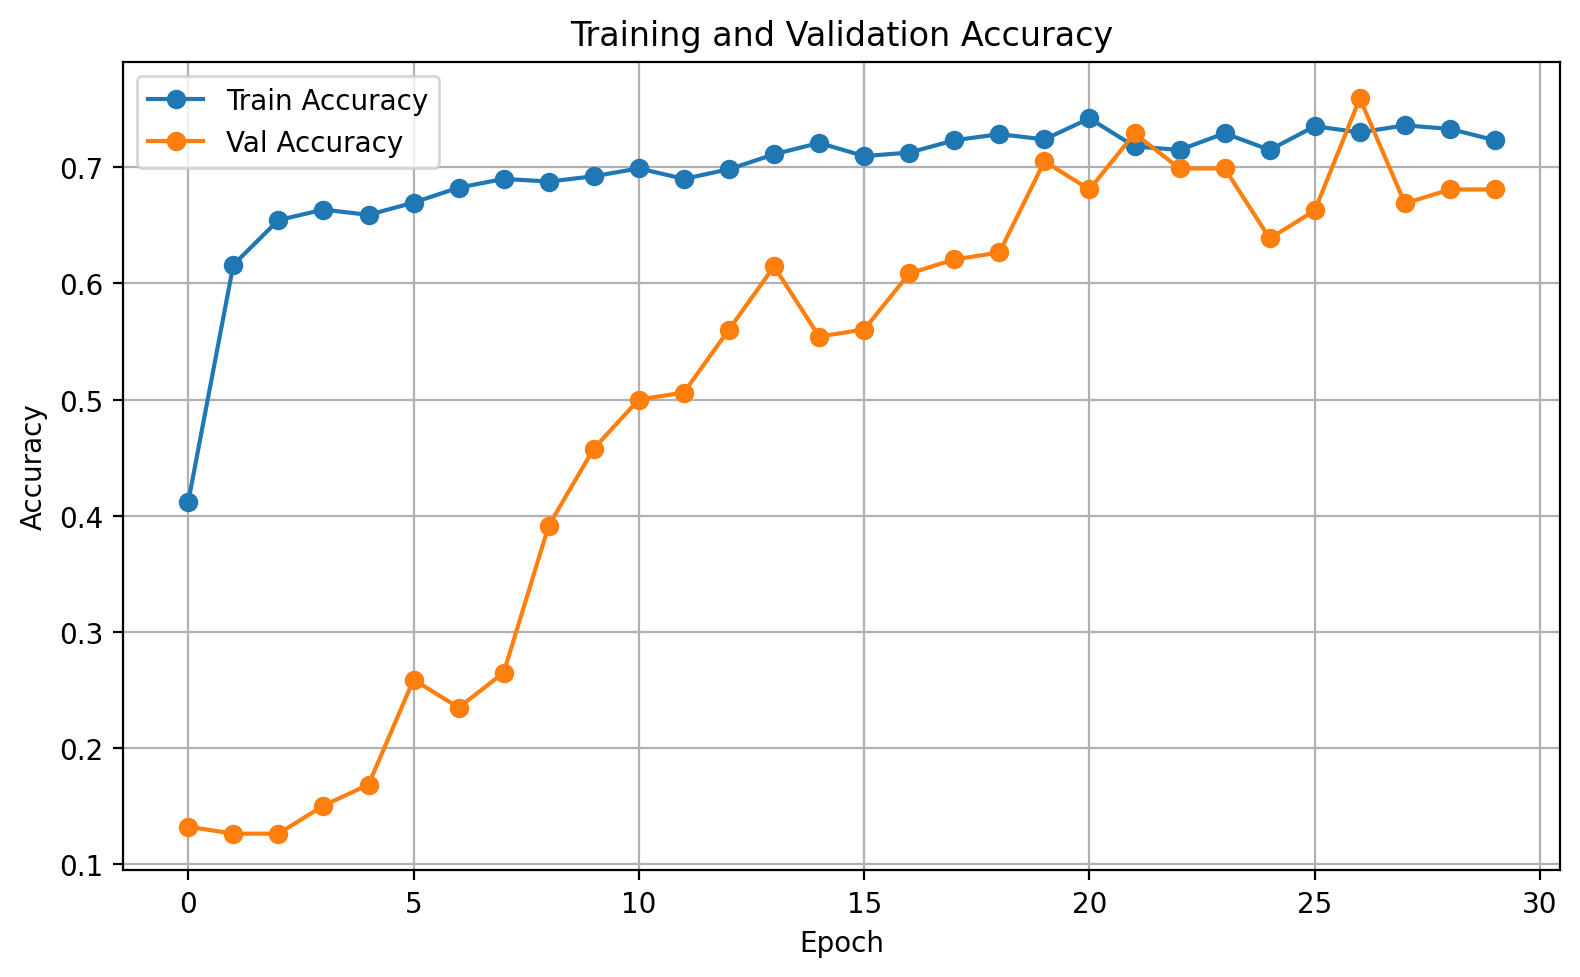

In [ ]:
# Plot accuracy
plot_accuracy(history_cnn)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


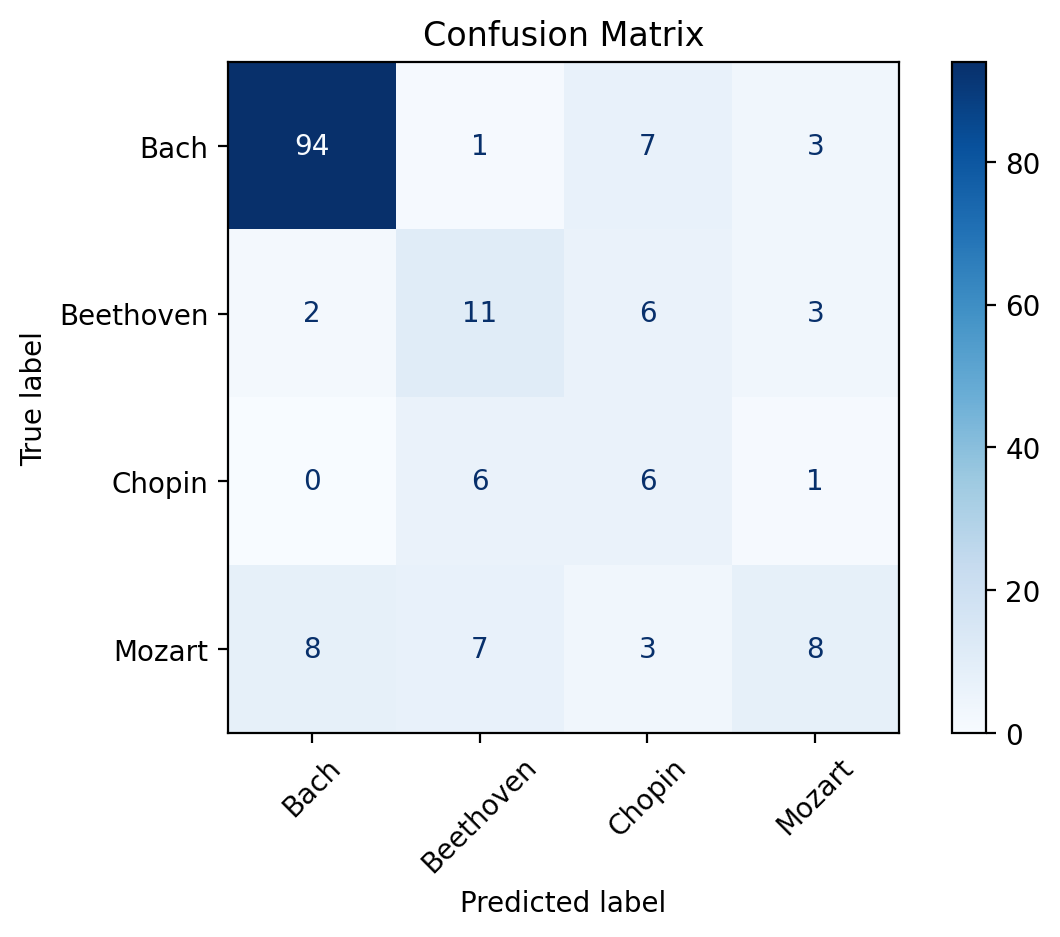

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model_cnn, X_test, y_test_cat, le.classes_)

In [ ]:
'''
# Data augmentation for minority classes
def augment_mel_spectrogram(mel, mode='time_shift'):
    if mode == 'time_shift':
        shift = np.random.randint(-20, 20)
        return np.roll(mel, shift, axis=0)
    elif mode == 'pitch_shift':
        bins = np.random.randint(-5, 5)
        return np.roll(mel, bins, axis=1)
    elif mode == 'add_noise':
        noise = 0.01 * np.random.randn(*mel.shape)
        return mel + noise
    elif mode == 'time_mask':
        mel = mel.copy()
        t = np.random.randint(0, mel.shape[0] - 10)
        mel[t:t+10, :] = 0
        return mel
    elif mode == 'freq_mask':
        mel = mel.copy()
        f = np.random.randint(0, mel.shape[1] - 10)
        mel[:, f:f+10] = 0
        return mel
    else:
        return mel  # No augmentation
'''
# Data augmentation for minority classes
def augment_mel_spectrogram(mel, mode='time_shift'):
    mel = mel.copy()  # avoid modifying original
    augmented = np.empty_like(mel)

    for ch in range(mel.shape[-1]):
        channel = mel[:, :, ch]

        if mode == 'time_shift':
            shift = np.random.randint(-20, 20)
            augmented[:, :, ch] = np.roll(channel, shift, axis=0)

        elif mode == 'pitch_shift':
            bins = np.random.randint(-5, 5)
            augmented[:, :, ch] = np.roll(channel, bins, axis=1)

        elif mode == 'add_noise':
            noise = 0.01 * np.random.randn(*channel.shape)
            augmented[:, :, ch] = channel + noise

        elif mode == 'time_mask':
            t = np.random.randint(0, channel.shape[0] - 10)
            channel[t:t+10, :] = 0
            augmented[:, :, ch] = channel

        elif mode == 'freq_mask':
            f = np.random.randint(0, channel.shape[1] - 10)
            channel[:, f:f+10] = 0
            augmented[:, :, ch] = channel

        else:
            augmented[:, :, ch] = channel

    return augmented


In [ ]:
'''
# Original dataset
X_aug, y_aug = list(X), list(y)
counts = Counter(y)

# Get target number (same as max class, e.g., Bach)
target_count = max(counts.values())

# For each class, augment until balanced
for cls in np.unique(y):
    cls_indices = [i for i, label in enumerate(y) if label == cls]
    while counts[cls] < target_count:
        idx = np.random.choice(cls_indices)
        mel = X[idx]
        mode = np.random.choice(['time_shift', 'pitch_shift', 'add_noise', 'time_mask', 'freq_mask'])
        mel_aug = augment_mel_spectrogram(mel, mode)
        X_aug.append(mel_aug)
        y_aug.append(cls)
        counts[cls] += 1
'''
from collections import Counter
import numpy as np

# Convert to lists for augmentation
X_aug, y_aug = list(X), list(y)

# Get current class counts
counts = Counter(y)
target_count = max(counts.values())

# Perform augmentation to balance classes
for cls in np.unique(y):
    cls_indices = [i for i, label in enumerate(y) if label == cls]
    print(f"Augmenting class {cls} from {counts[cls]} to {target_count}")

    while counts[cls] < target_count:
        idx = np.random.choice(cls_indices)
        mel = X[idx]
        mode = np.random.choice(['time_shift', 'pitch_shift', 'add_noise', 'time_mask', 'freq_mask'])

        try:
            mel_aug = augment_mel_spectrogram(mel, mode)
            X_aug.append(mel_aug)
            y_aug.append(cls)
            counts[cls] += 1
        except Exception as e:
            print(f"Augmentation failed for class {cls}: {e}")


Augmenting class 0 from 1050 to 1050
Augmenting class 1 from 212 to 1050
Augmenting class 2 from 137 to 1050
Augmenting class 3 from 258 to 1050


In [ ]:
# Convert to numpy arrays
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

# One-hot encode y_aug
from keras.utils import to_categorical
y_aug_cat = to_categorical(y_aug, num_classes=num_classes)


In [ ]:
# Split again into train/val/test, then retrain the model
# Train/validation/test split
X_aug_train, X_aug_temp, y_aug_train, y_aug_temp = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=42)
X_aug_val, X_aug_test, y_aug_val, y_aug_test = train_test_split(X_aug_temp, y_aug_temp, test_size=0.5, stratify=y_aug_temp, random_state=42)

print(f"Shape of X: {X_aug.shape}")
print(f"Shape of y: {y_aug.shape}")
print(f"Num of classes: {num_classes}")

Shape of X: (4200, 256, 128, 2)
Shape of y: (4200,)
Num of classes: 4


In [ ]:
# Reshape input to (samples, 256, 128, 1)
#X_aug_train_cnn = X_aug_train[..., np.newaxis]
#X_aug_val_cnn = X_aug_val[..., np.newaxis]
#X_aug_test_cnn = X_aug_test[..., np.newaxis]

y_aug_train_cat = to_categorical(y_aug_train, num_classes=num_classes)
y_aug_val_cat   = to_categorical(y_aug_val, num_classes=num_classes)
y_aug_test_cat  = to_categorical(y_aug_test, num_classes=num_classes)

In [ ]:
print("X_aug_train:", X_aug_train.shape)          # (num_samples, 256, 128[, 1])
print("y_aug_train_cat:", y_aug_train_cat.shape)  # (num_samples, num_classes)
print("X_aug_val:", X_aug_val.shape)              # (num_val_samples, 256, 128[, 1])
print("y_aug_val_cat:", y_aug_val_cat.shape)      # (num_val_samples, num_classes)

X_aug_train: (3360, 256, 128, 2)
y_aug_train_cat: (3360, 4)
X_aug_val: (420, 256, 128, 2)
y_aug_val_cat: (420, 4)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug), y=y_aug)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
#X_aug_train = X_aug_train.reshape(-1, 256, 128, 1)
#X_aug_val = X_aug_val.reshape(-1, 256, 128, 1)
#X_aug_test = X_aug_test.reshape(-1, 256, 128, 1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_aug_cnn = model_cnn.fit(X_aug_train, y_aug_train_cat,
                    validation_data=(X_aug_val, y_aug_val_cat),
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4549 - loss: 1.2638 - val_accuracy: 0.4095 - val_loss: 1.2051
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4910 - loss: 1.1460 - val_accuracy: 0.4452 - val_loss: 1.1743
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5275 - loss: 1.0969 - val_accuracy: 0.4238 - val_loss: 1.1831
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5298 - loss: 1.0593 - val_accuracy: 0.4143 - val_loss: 1.2096
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5545 - loss: 1.0493 - val_accuracy: 0.5143 - val_loss: 1.1110
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5418 - loss: 1.0452 - val_accuracy: 0.5667 - val_loss: 1.0527
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5662 - loss: 1.0216 - val_accuracy: 0.5405 - val_loss: 1.0665
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5548 - loss: 1.0025 - val_accu

In [ ]:
# Evaluate the trained model
test_loss, test_accuracy = model_cnn.evaluate(X_aug_test, y_aug_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8798
Test Accuracy: 0.6548


In [ ]:
y_pred = model_cnn.predict(X_aug_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_aug_val, y_pred_classes, target_names=le.classes_))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
              precision    recall  f1-score   support

        Bach       0.78      0.90      0.83       105
   Beethoven       0.66      0.47      0.55       105
      Chopin       0.61      0.79      0.69       105
      Mozart       0.69      0.58      0.63       105

    accuracy                           0.68       420
   macro avg       0.68      0.68      0.67       420
weighted avg       0.68      0.68      0.67       420



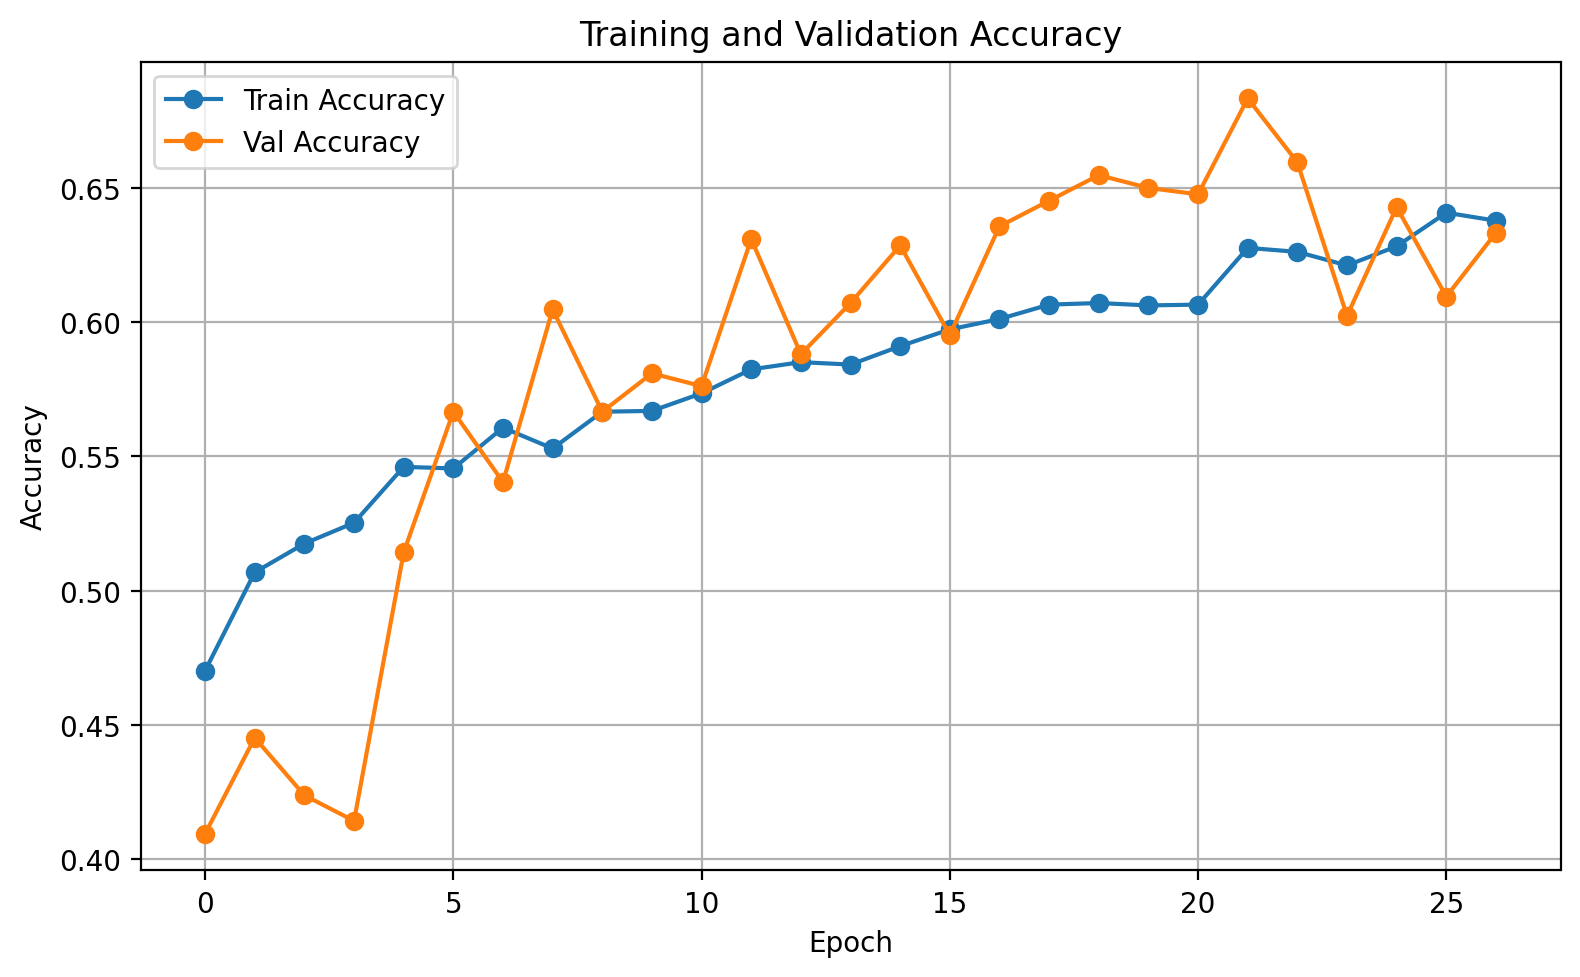

In [ ]:
# Plot accuracy
plot_accuracy(history_aug_cnn)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step


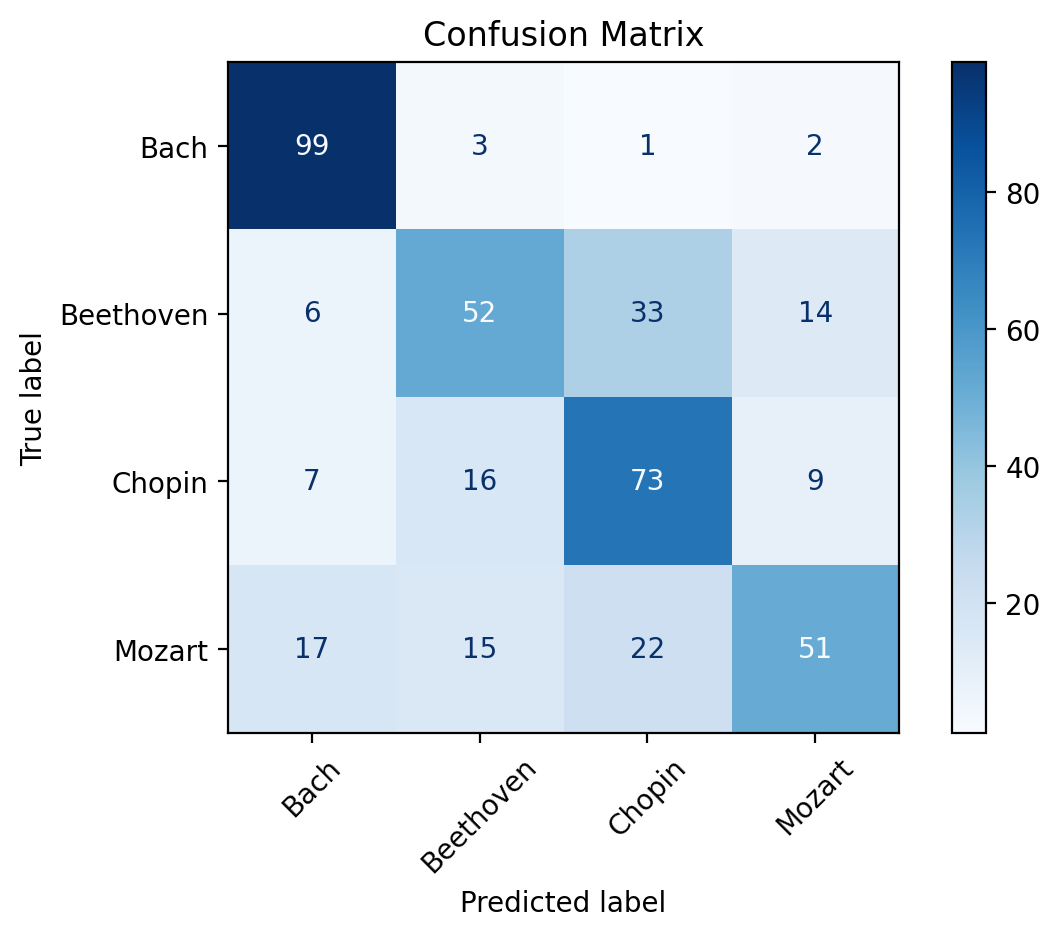

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model_cnn, X_aug_test, y_aug_test_cat, le.classes_)

## CNN Model Optimization

In [ ]:
input_shape = (256, 128, 2)
num_classes = len(le.classes_)  # already computed

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), padding='same')(inputs)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_opt_cnn = Model(inputs, outputs)
model_opt_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_opt_cnn.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 128, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 128, 32)   │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,540 (1.61 MB)

 Trainable params: 421,540 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_opt_cnn = model_opt_cnn.fit(
    X_aug_train, y_aug_train_cat,
    validation_data=(X_aug_val, y_aug_val_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - accuracy: 0.7387 - loss: 0.5941 - val_accuracy: 0.7071 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.7367 - loss: 0.6407 - val_accuracy: 0.7429 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - accuracy: 0.7535 - loss: 0.5811 - val_accuracy: 0.6762 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - accuracy: 0.7574 - loss: 0.5941 - val_accuracy: 0.7357 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.7700 - loss: 0.5352 - val_accuracy: 0.7738 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.7812 - loss: 0.5300 - val_accuracy: 0.7714 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.7

In [ ]:
# Evaluate the trained model
test_loss, test_accuracy = model_opt_cnn.evaluate(X_aug_test, y_aug_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5145
Test Accuracy: 0.8429


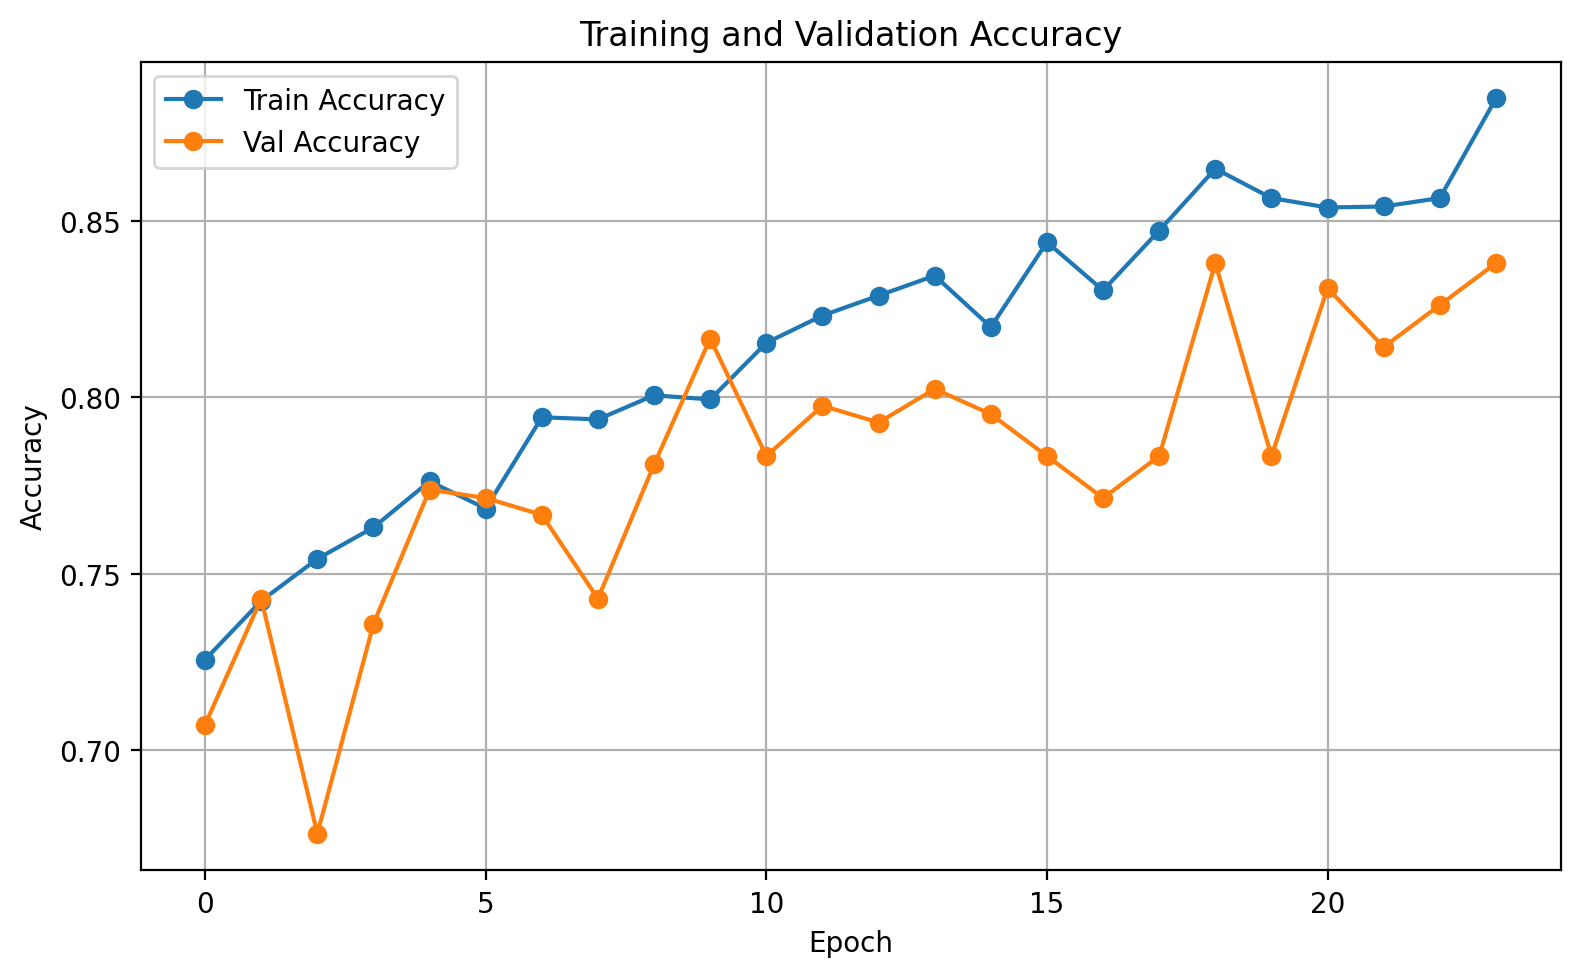

In [ ]:
# Plot accuracy
plot_accuracy(history_opt_cnn)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


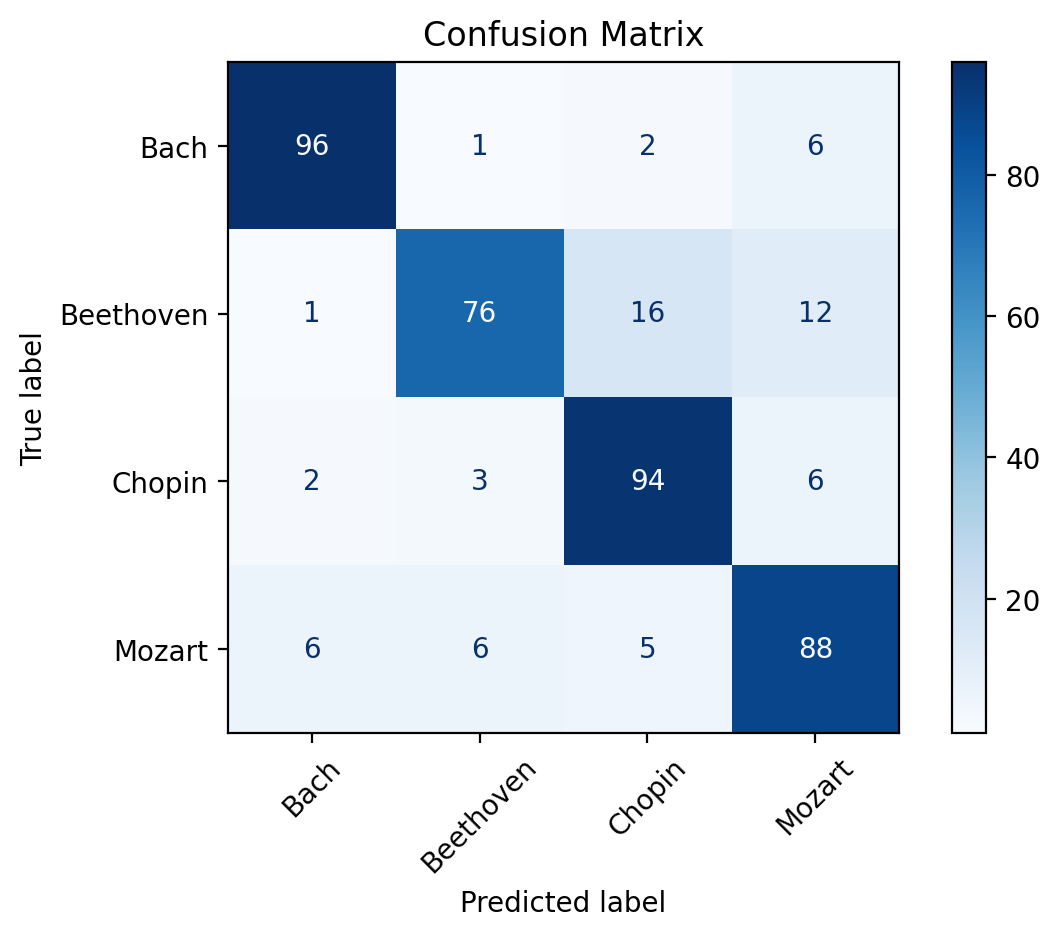

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model_opt_cnn, X_aug_test, y_aug_test_cat, le.classes_)

In [ ]:
y_pred = model_opt_cnn.predict(X_aug_val)

# Convert to class labels
y_pred_classes = y_pred.argmax(axis=1)

# Classification Report
print(classification_report(y_aug_val, y_pred_classes, target_names=le.classes_))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
              precision    recall  f1-score   support

        Bach       0.92      0.92      0.92       105
   Beethoven       0.84      0.77      0.81       105
      Chopin       0.80      0.88      0.84       105
      Mozart       0.80      0.78      0.79       105

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420

